# SIOT Correlation

This code processes the data obtained in the #ClimateChange SIOT project. This compares the sentiment of Tweets in relation to Climate Change compared to the local weather. This was initially done for London and Sydney, to see whether the current environmental wildfire disaster has any effect on residents' climate change sentiment. 

The data imported is gathered from OpenWeatherMaps API and Twitter API through two Google Sheets: 'London' and 'Sydney'. Weather data is compiled of: Time, City, Description, Wind Speed, Temperature and Visibility, and Twitter data is compiled of: Number of Tweets, % of Positive Sentiment, % of Negative Sentiment and % of Neutral Sentiment.

The Jupiter Notebook imports, modifies, visualises, normalises and correlates the datasets. This will determine if these time-series datasets have any relationship which could be used to help prevent climate change. 


## 1. Importing Packages

In [204]:
import re 
import time
import datetime
from datetime import datetime
import multiprocessing
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import os, sys
from pprint import pprint
import requests
import matplotlib 
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from wordcloud import WordCloud
import matplotlib.patches as mpatches
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
#from pandas_datareader import data
from sklearn.preprocessing import Imputer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
plt.style.use('fivethirtyeight') 
plt.rcParams.update({'font.size': 20})

## 2. Importing Google Sheets

Each Google Sheet is read as a csv; datetimes are added for easy data manipulation and correlation. Weather 'description' data is changed from text data into numerial data so it can be correlated to twitter sentiment. 

In [205]:
#London Google Sheet - to be modified
LondonCSV = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
                   '117egHTjN83sK1sKHnLqVQAWEURCPCtQA_zof7IzUVKA' +
                   '/export?gid=0&format=csv',
                   index_col='Datetime',
                   parse_dates=['Datetime']
                  )
#London Google Sheet - unmodified for subsequent plotting
LondonCSVWW = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
                   '117egHTjN83sK1sKHnLqVQAWEURCPCtQA_zof7IzUVKA' +
                   '/export?gid=0&format=csv',
                   index_col='Datetime',
                   parse_dates=['Datetime']
                  )

LondonCSV.Weather = LondonCSV.Weather.fillna('no_data') 
Weather = {'no_data':0, 'clear sky': 1, 'haze': 2, 'overcast clouds': 6, 'broken clouds': 5, 'scattered clouds': 4, 'few clouds': 3, 'mist': 7, 'fog': 8, 'light rain': 9, 'light intensity drizzle': 10, 'light intensity drizzle rain': 11, 'drizzle': 12, 'drizzle rain': 13, 'moderate rain': 14, 'shower rain': 15}
LondonCSV.Weather = [Weather[item] for item in LondonCSV.Weather] #changing weather 'descriptions' to numbers, so that it can be averaged and compared
#LondonCSV.head(5)

#Sydney Google Sheet - to be modified
SydneyCSV = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
                   '1NWTsQDZ8hxE6lMSpcjB_gvqisZl_aP6K3ttKgfyxC7Q' +
                   '/export?gid=0&format=csv',
                   index_col='Datetime',
                   parse_dates=['Datetime']
                  )
#Sydney Google Sheet - unmodified for subsequent plotting
SydneyCSVWW = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
                   '1NWTsQDZ8hxE6lMSpcjB_gvqisZl_aP6K3ttKgfyxC7Q' +
                   '/export?gid=0&format=csv',
                   index_col='Datetime',
                   parse_dates=['Datetime']
                  )

SydneyCSV.Weather = SydneyCSV.Weather.fillna('no_data') 
Weather = {'no_data':0, 'clear sky': 1, 'haze': 2, 'overcast clouds': 6, 'broken clouds': 5, 'scattered clouds': 4, 'few clouds': 3, 'mist': 7, 'fog': 8, 'light rain': 9, 'light intensity drizzle': 10, 'light intensity drizzle rain': 11, 'drizzle': 12, 'drizzle rain': 13, 'moderate rain': 14, 'shower rain': 16, 'smoke': 18, 'light intensity shower rain': 15, 'thunderstorm': 19}
SydneyCSV.Weather = [Weather[item] for item in SydneyCSV.Weather] #changing weather 'descriptions' to numbers, so that it can be averaged and compared
#SydneyCSV.head(5)

## 3. Data Pre-processing

London and Sydney Data: Weather and Twitter, averaged in hours and then across days. 

In [206]:
HourSampleL = LondonCSV.resample('H').mean() #hourly mean samples of twitter & weather data for London
HourSampleL = HourSampleL.dropna()

DaySampleL = LondonCSV.resample('D').mean() #Daily mean samples of twitter & weather data for London
DaySampleL = DaySampleL.dropna()

HourSampleS = SydneyCSV.resample('H').mean() #hourly mean samples of twitter & weather data for Sydney
HourSampleS = HourSampleS.dropna()

DaySampleS = SydneyCSV.resample('D').mean() #Daily mean samples of twitter & weather data for Sydney
DaySampleS = DaySampleS.dropna()

# 4. Timeline of the Data: Weather & Twitter

# Weather Data

## A) Hourly London Weather Data

<Figure size 2160x720 with 0 Axes>

Text(0, 0.5, 'Values')

Text(0.5, 1.0, 'Hourly London Weather')

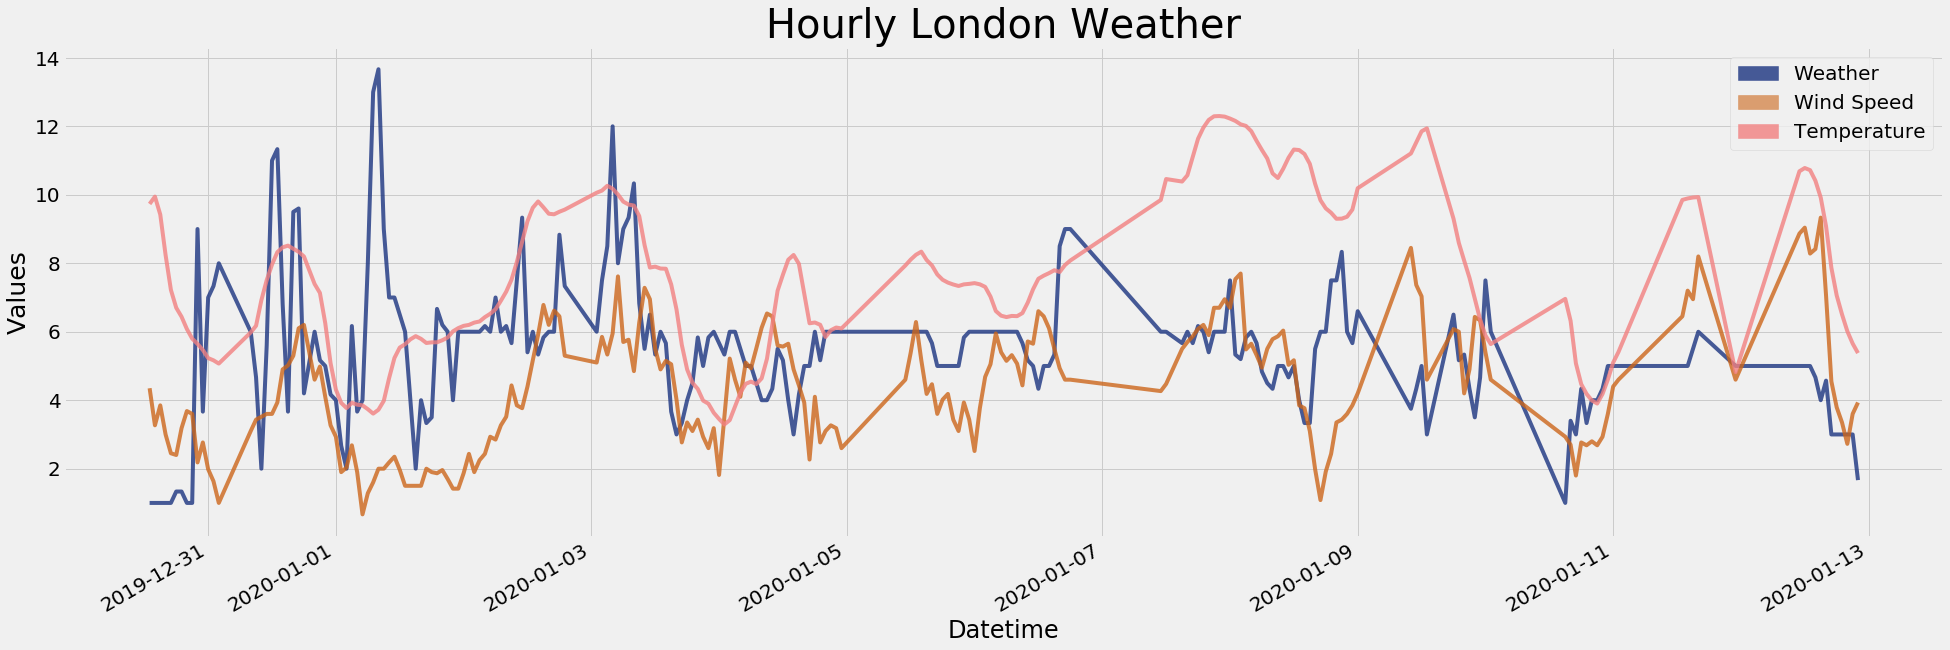

In [207]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(30, 10))
plt.ylabel('Values', fontsize = 25)
plt.title("Hourly London Weather", fontsize = 40)

HourSampleL.Weather.plot(figsize=(30, 10), color=(0.1, 0.2, 0.5, 0.8))
HourSampleL.Wind_Speed.plot(figsize=(30, 10), color=(0.8, 0.4, 0.1, 0.8))
HourSampleL.Temperature.plot(figsize=(30, 10), color=(0.95, 0.5, 0.5, 0.8))

label1 = mpatches.Patch(color=(0.1, 0.2, 0.5, 0.8), label='Weather')
label2 = mpatches.Patch(color=(0.8, 0.4, 0.1, 0.6), label='Wind Speed')
label3 = mpatches.Patch(color=(0.95, 0.5, 0.5, 0.8), label='Temperature')

plt.legend(handles=[label1,label2,label3])
plt.savefig('./Graphs/HourlyLondonWeatherData.png')

## B) Daily London Weather Data

<Figure size 2160x720 with 0 Axes>

Text(0, 0.5, 'Values')

Text(0.5, 1.0, 'Daily London Weather')

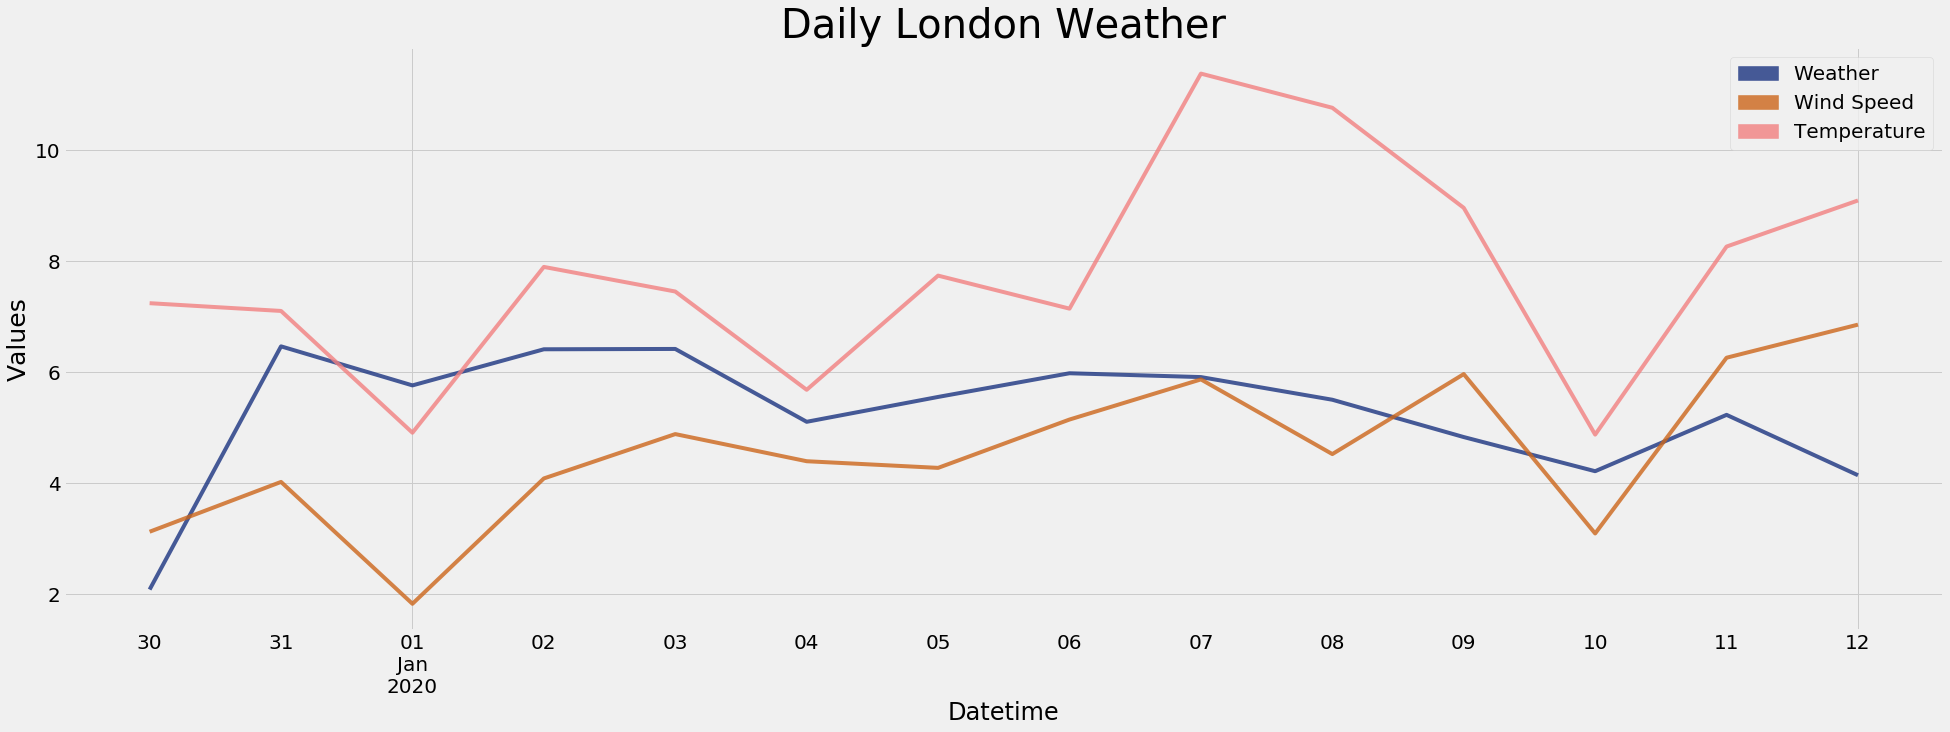

In [208]:
plt.figure(figsize=(30, 10))
plt.ylabel('Values', fontsize = 25)
plt.title("Daily London Weather", fontsize = 40)

DaySampleL.Weather.plot(figsize=(30, 10), color=(0.1, 0.2, 0.5, 0.8))
DaySampleL.Wind_Speed.plot(figsize=(30, 10), color=(0.8, 0.4, 0.1, 0.8))
DaySampleL.Temperature.plot(figsize=(30, 10), color=(0.95, 0.5, 0.5, 0.8))

label1 = mpatches.Patch(color=(0.1, 0.2, 0.5, 0.8), label='Weather')
label2 = mpatches.Patch(color=(0.8, 0.4, 0.1, 0.8), label='Wind Speed')
label3 = mpatches.Patch(color=(0.95, 0.5, 0.5, 0.8), label='Temperature')

plt.legend(handles=[label1,label2,label3])
plt.savefig('./Graphs/DailyLondonWeatherData.png')

## C) Hourly Sydney Weather Data

<Figure size 2160x720 with 0 Axes>

Text(0, 0.5, 'Values')

Text(0.5, 1.0, 'Hourly Sydney Weather')

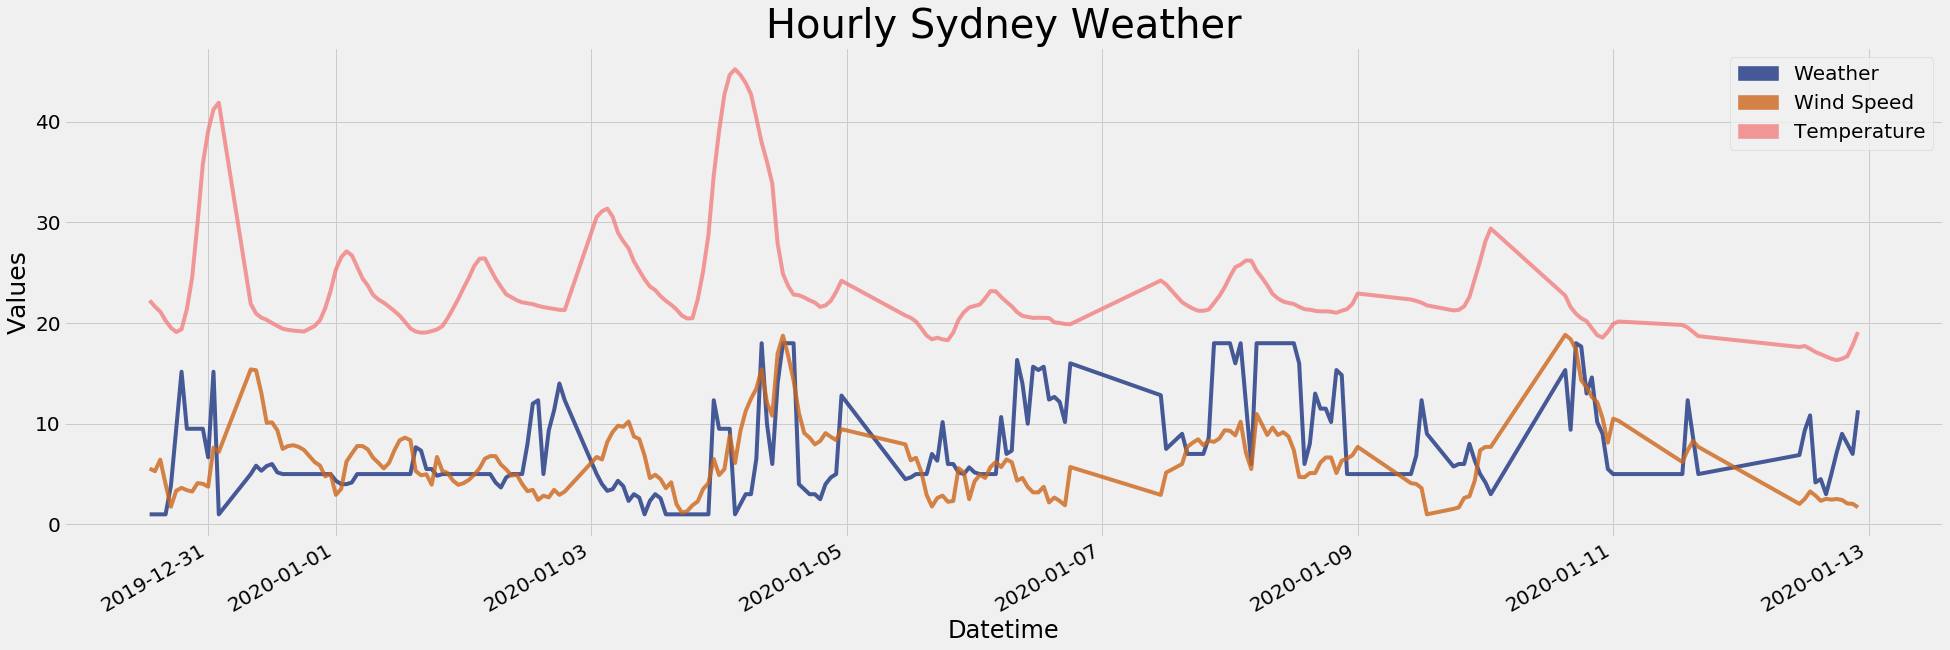

In [209]:
plt.figure(figsize=(30, 10))
plt.ylabel('Values', fontsize = 25)
plt.title("Hourly Sydney Weather", fontsize = 40)

HourSampleS.Weather.plot(figsize=(30, 10), color=(0.1, 0.2, 0.5, 0.8))
HourSampleS.Wind_Speed.plot(figsize=(30, 10), color=(0.8, 0.4, 0.1, 0.8))
HourSampleS.Temperature.plot(figsize=(30, 10), color=(0.95, 0.5, 0.5, 0.8))

label1 = mpatches.Patch(color=(0.1, 0.2, 0.5, 0.8), label='Weather')
label2 = mpatches.Patch(color=(0.8, 0.4, 0.1, 0.8), label='Wind Speed')
label3 = mpatches.Patch(color=(0.95, 0.5, 0.5, 0.8), label='Temperature')

plt.legend(handles=[label1,label2,label3])
plt.savefig('./Graphs/HourlySydneyWeatherData.png')


## D) Daily Sydney Weather Data

<Figure size 2160x720 with 0 Axes>

Text(0, 0.5, 'Values')

Text(0.5, 1.0, 'Daily Sydney Weather')

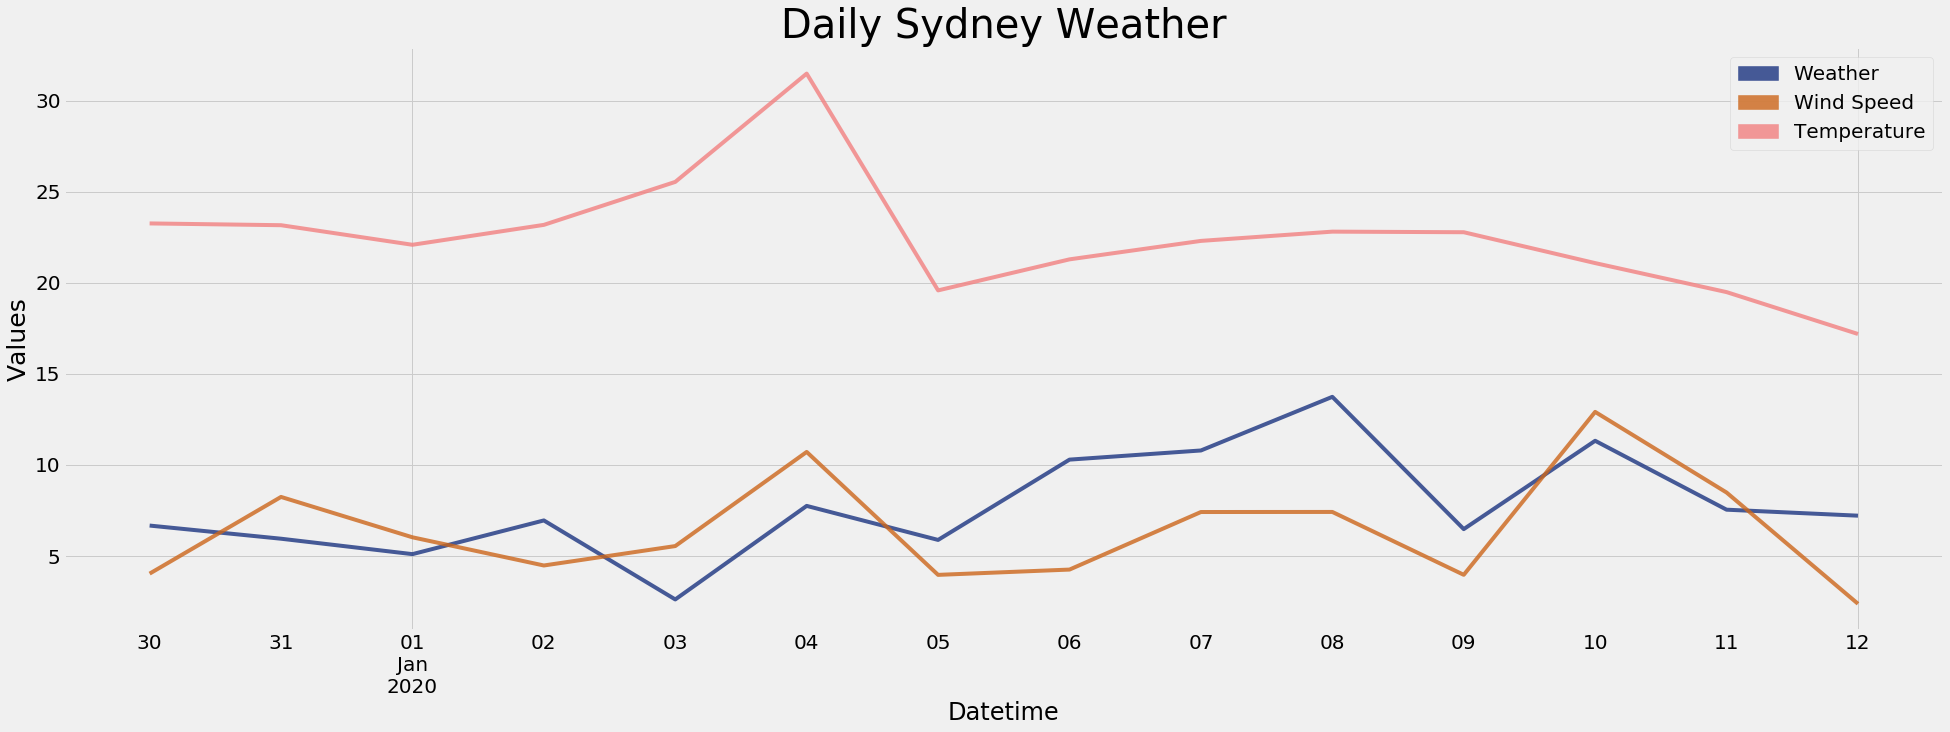

In [210]:
plt.figure(figsize=(30, 10))
plt.ylabel('Values', fontsize = 25)
plt.title("Daily Sydney Weather", fontsize = 40)

DaySampleS.Weather.plot(figsize=(30, 10), color=(0.1, 0.2, 0.5, 0.8))
DaySampleS.Wind_Speed.plot(figsize=(30, 10), color=(0.8, 0.4, 0.1, 0.8))
DaySampleS.Temperature.plot(figsize=(30, 10), color=(0.95, 0.5, 0.5, 0.8))

label1 = mpatches.Patch(color=(0.1, 0.2, 0.5, 0.8), label='Weather')
label2 = mpatches.Patch(color=(0.8, 0.4, 0.1, 0.8), label='Wind Speed')
label3 = mpatches.Patch(color=(0.95, 0.5, 0.5, 0.8), label='Temperature')

plt.legend(handles=[label1,label2,label3])
plt.savefig('./Graphs/DailySydneyWeatherData.png')

# Twitter Data

## A) Hourly London Twitter Data

<Figure size 2160x720 with 0 Axes>

Text(0, 0.5, 'Values')

Text(0.5, 1.0, 'Hourly London Twitter Data')

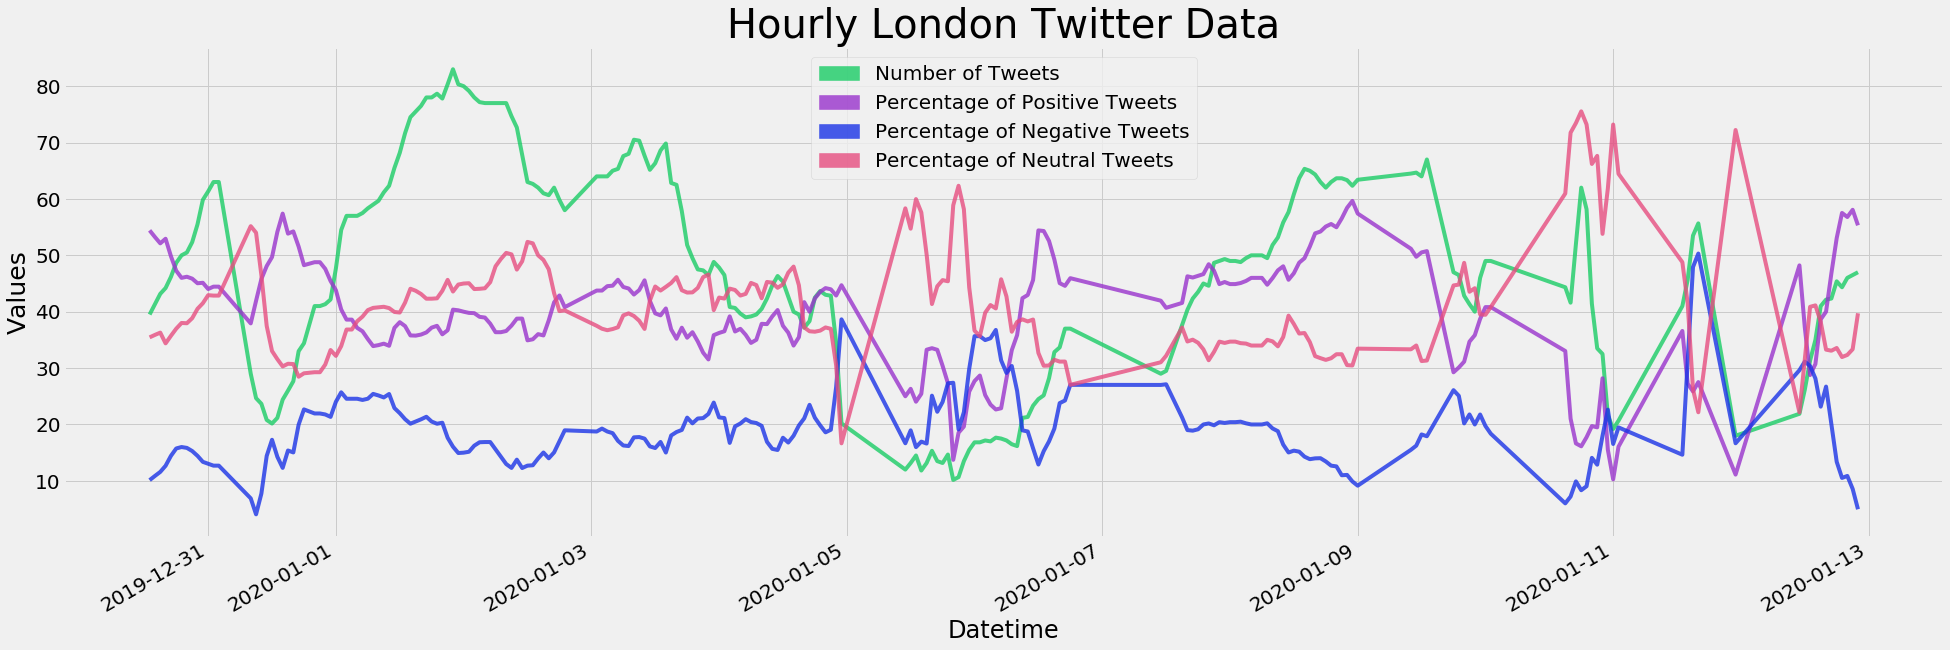

In [211]:
plt.figure(figsize=(30, 10))
plt.ylabel('Values', fontsize = 25)
plt.title("Hourly London Twitter Data", fontsize = 40)

HourSampleL.NumberTweets.plot(figsize=(30, 10), color=(0.1, 0.8, 0.4, 0.8))
HourSampleL.Positive_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.6, 0.2, 0.8, 0.8))
HourSampleL.Negetive_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.1, 0.2, 0.9, 0.8))
HourSampleL.Neutral_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.9, 0.3, 0.5, 0.8))

label1 = mpatches.Patch(color=(0.1, 0.8, 0.4, 0.8), label='Number of Tweets')
label2 = mpatches.Patch(color=(0.6, 0.2, 0.8, 0.8), label='Percentage of Positive Tweets')
label3 = mpatches.Patch(color=(0.1, 0.2, 0.9, 0.8), label='Percentage of Negative Tweets')
label4 = mpatches.Patch(color=(0.9, 0.3, 0.5, 0.8), label='Percentage of Neutral Tweets')
plt.legend(handles=[label1,label2,label3, label4])
plt.savefig('./Graphs/HourlyLondonTwitterData.png')

## B) Daily London Twitter Data

<Figure size 2160x720 with 0 Axes>

Text(0, 0.5, 'Values')

Text(0.5, 1.0, 'Daily London Twitter Data')

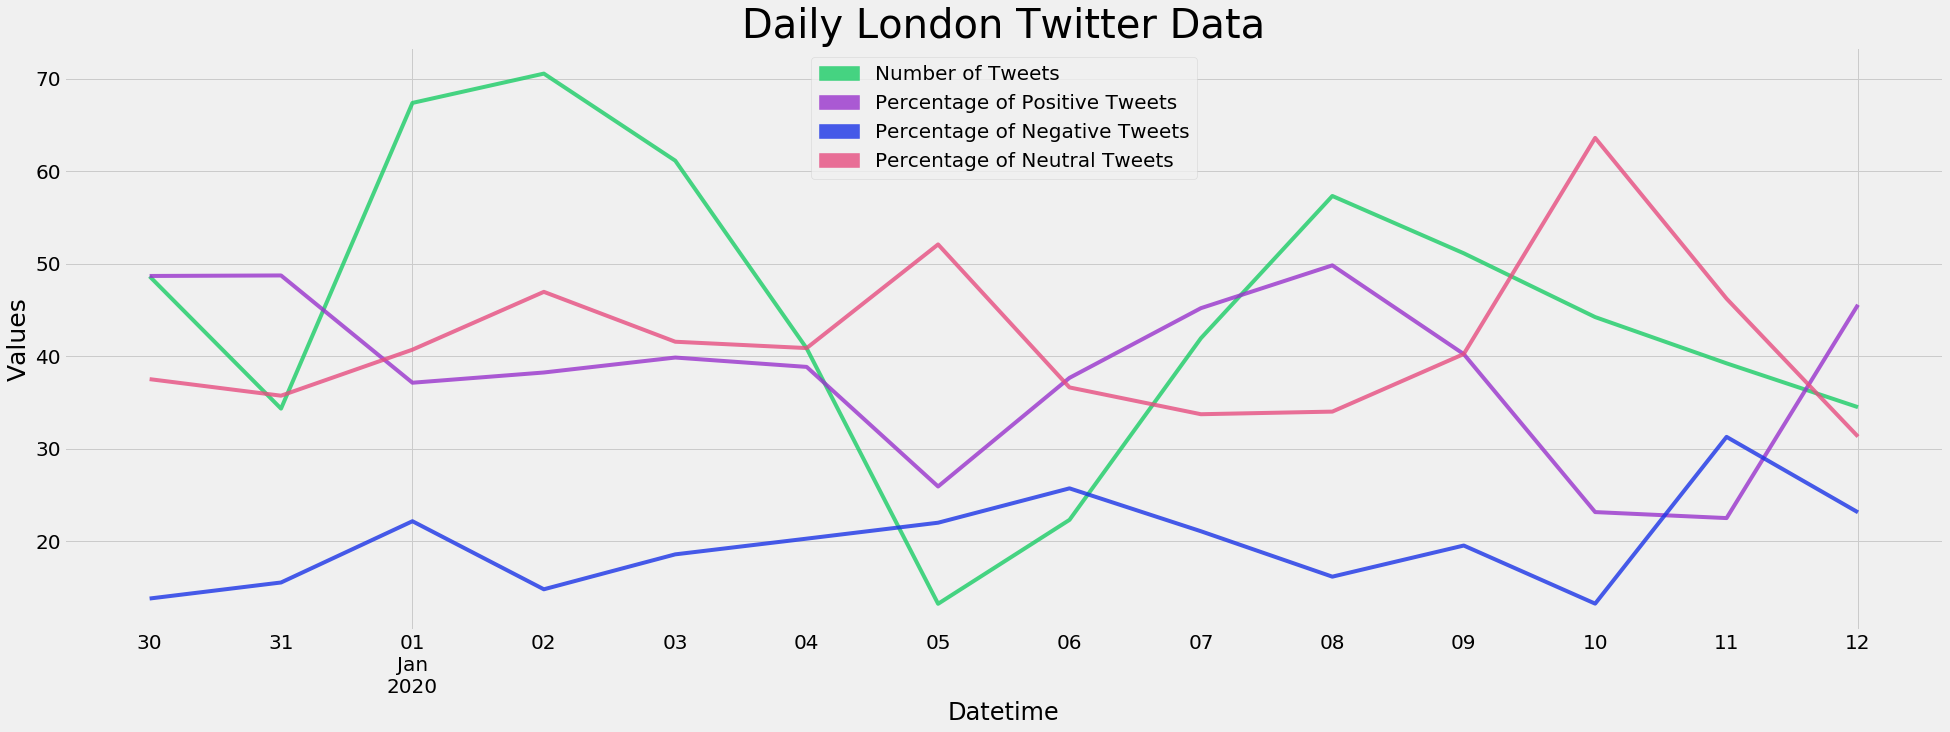

In [212]:
plt.figure(figsize=(30, 10))
plt.ylabel('Values', fontsize = 25)
plt.title("Daily London Twitter Data", fontsize = 40)

DaySampleL.NumberTweets.plot(figsize=(30, 10), color=(0.1, 0.8, 0.4, 0.8))
DaySampleL.Positive_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.6, 0.2, 0.8, 0.8))
DaySampleL.Negetive_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.1, 0.2, 0.9, 0.8))
DaySampleL.Neutral_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.9, 0.3, 0.5, 0.8))

label1 = mpatches.Patch(color=(0.1, 0.8, 0.4, 0.8), label='Number of Tweets')
label2 = mpatches.Patch(color=(0.6, 0.2, 0.8, 0.8), label='Percentage of Positive Tweets')
label3 = mpatches.Patch(color=(0.1, 0.2, 0.9, 0.8), label='Percentage of Negative Tweets')
label4 = mpatches.Patch(color=(0.9, 0.3, 0.5, 0.8), label='Percentage of Neutral Tweets')
plt.legend(handles=[label1,label2,label3, label4])
plt.savefig('./Graphs/DailyLondonTwitterData.png')

## C) Hourly Sydney Twitter Data

<Figure size 2160x720 with 0 Axes>

Text(0, 0.5, 'Values')

Text(0.5, 1.0, 'Hourly Sydney Twitter Data')

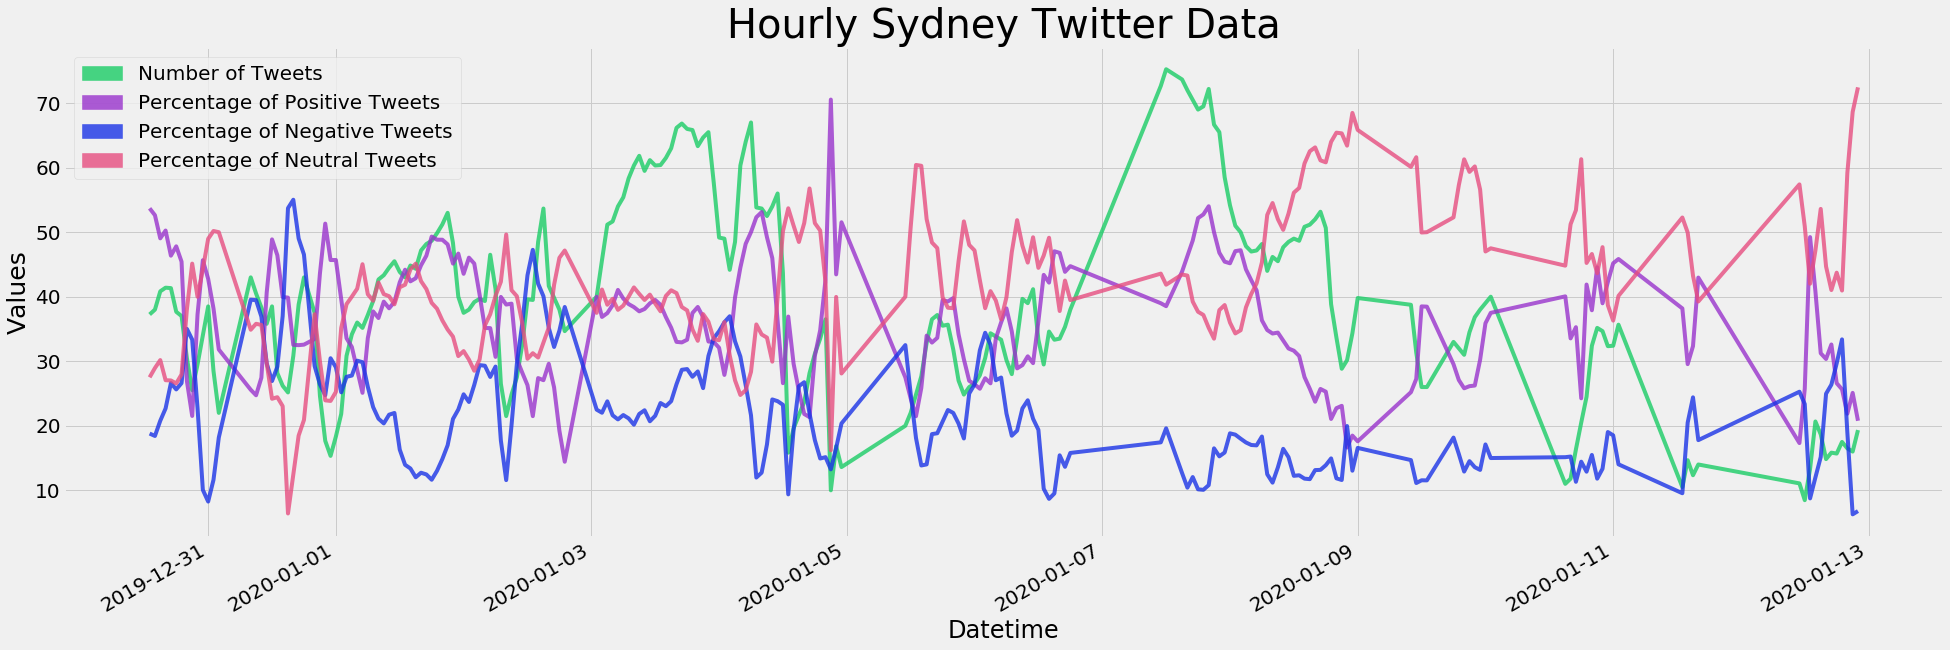

In [213]:
plt.figure(figsize=(30, 10))
plt.ylabel('Values', fontsize = 25)
plt.title("Hourly Sydney Twitter Data", fontsize = 40)

HourSampleS.NumberTweets.plot(figsize=(30, 10), color=(0.1, 0.8, 0.4, 0.8))
HourSampleS.Positive_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.6, 0.2, 0.8, 0.8))
HourSampleS.Negetive_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.1, 0.2, 0.9, 0.8))
HourSampleS.Neutral_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.9, 0.3, 0.5, 0.8))

label1 = mpatches.Patch(color=(0.1, 0.8, 0.4, 0.8), label='Number of Tweets')
label2 = mpatches.Patch(color=(0.6, 0.2, 0.8, 0.8), label='Percentage of Positive Tweets')
label3 = mpatches.Patch(color=(0.1, 0.2, 0.9, 0.8), label='Percentage of Negative Tweets')
label4 = mpatches.Patch(color=(0.9, 0.3, 0.5, 0.8), label='Percentage of Neutral Tweets')
plt.legend(handles=[label1,label2,label3, label4])
plt.savefig('./Graphs/HourlySydneyTwitterData.png')

## D) Daily Sydney Twitter Data

<Figure size 2160x720 with 0 Axes>

Text(0, 0.5, 'Values')

Text(0.5, 1.0, 'Daily Sydney Twitter Data')

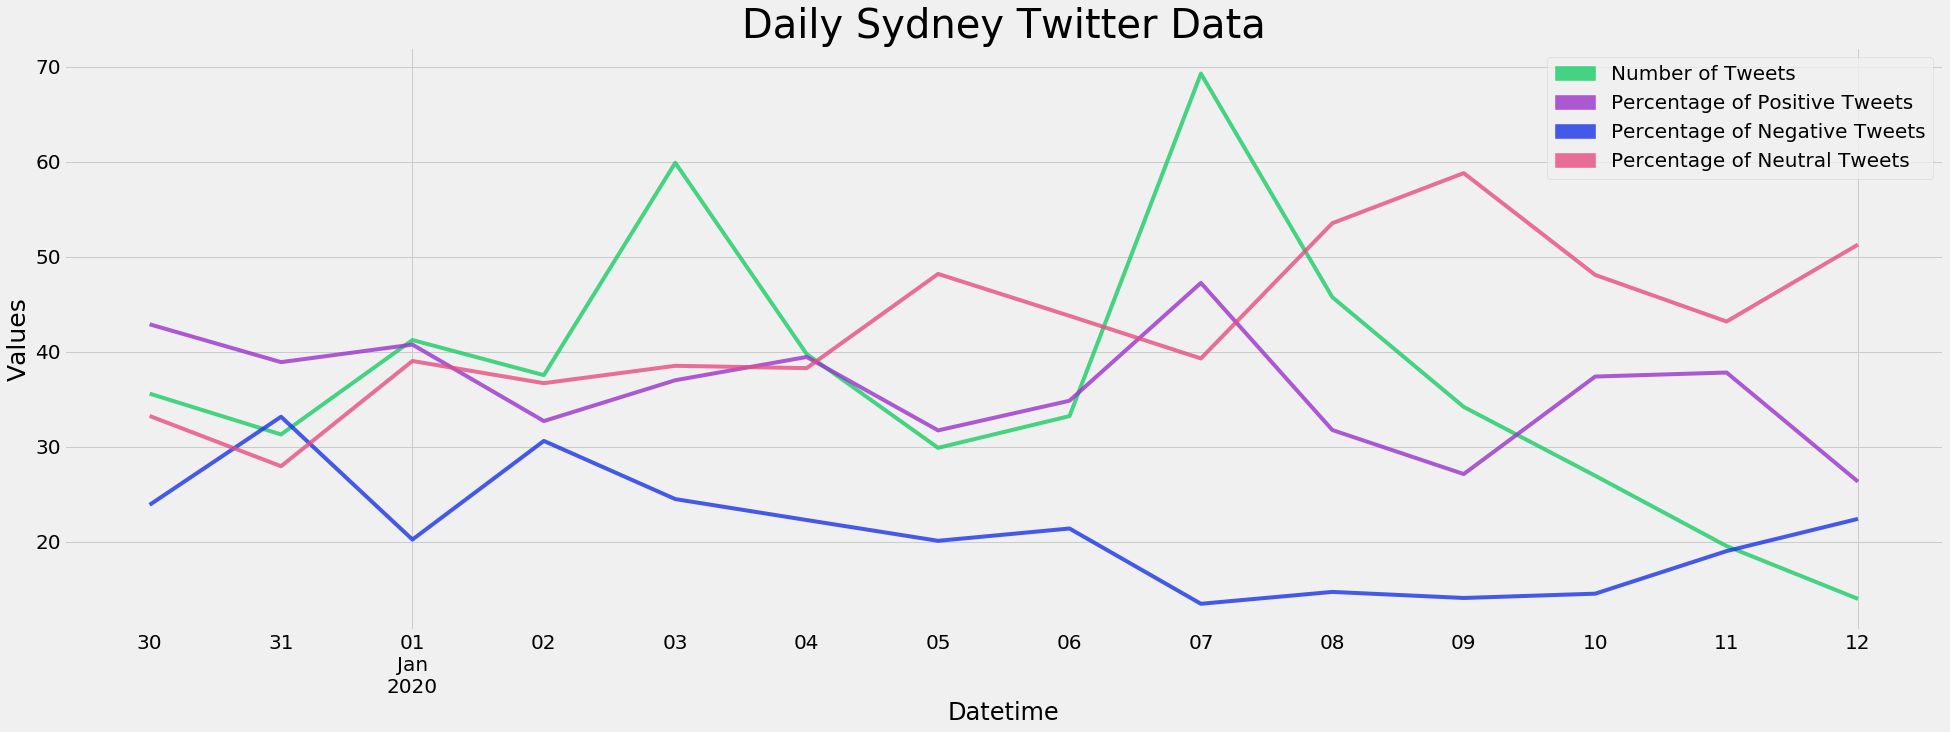

In [214]:
plt.figure(figsize=(30, 10))
plt.ylabel('Values', fontsize = 25)
plt.title("Daily Sydney Twitter Data", fontsize = 40)

DaySampleS.NumberTweets.plot(figsize=(30, 10), color=(0.1, 0.8, 0.4, 0.8))
DaySampleS.Positive_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.6, 0.2, 0.8, 0.8))
DaySampleS.Negetive_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.1, 0.2, 0.9, 0.8))
DaySampleS.Neutral_Percentage_Climate_Tweets.plot(figsize=(30, 10), color=(0.9, 0.3, 0.5, 0.8))

label1 = mpatches.Patch(color=(0.1, 0.8, 0.4, 0.8), label='Number of Tweets')
label2 = mpatches.Patch(color=(0.6, 0.2, 0.8, 0.8), label='Percentage of Positive Tweets')
label3 = mpatches.Patch(color=(0.1, 0.2, 0.9, 0.8), label='Percentage of Negative Tweets')
label4 = mpatches.Patch(color=(0.9, 0.3, 0.5, 0.8), label='Percentage of Neutral Tweets')
plt.legend(handles=[label1,label2,label3, label4])
plt.savefig('./Graphs/DailySydneyTwitterData.png')

# 5. Normalisation 

### Hourly Normalised Data in London - Twitter VS Weather

<Figure size 2160x720 with 0 Axes>

Text(0.5, 0, 'Datetime')

Text(0, 0.5, 'Normalised Values')

Text(0.5, 1.0, 'Normalised Twitter and Weather Data in London over Ten Days (Hourly)')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

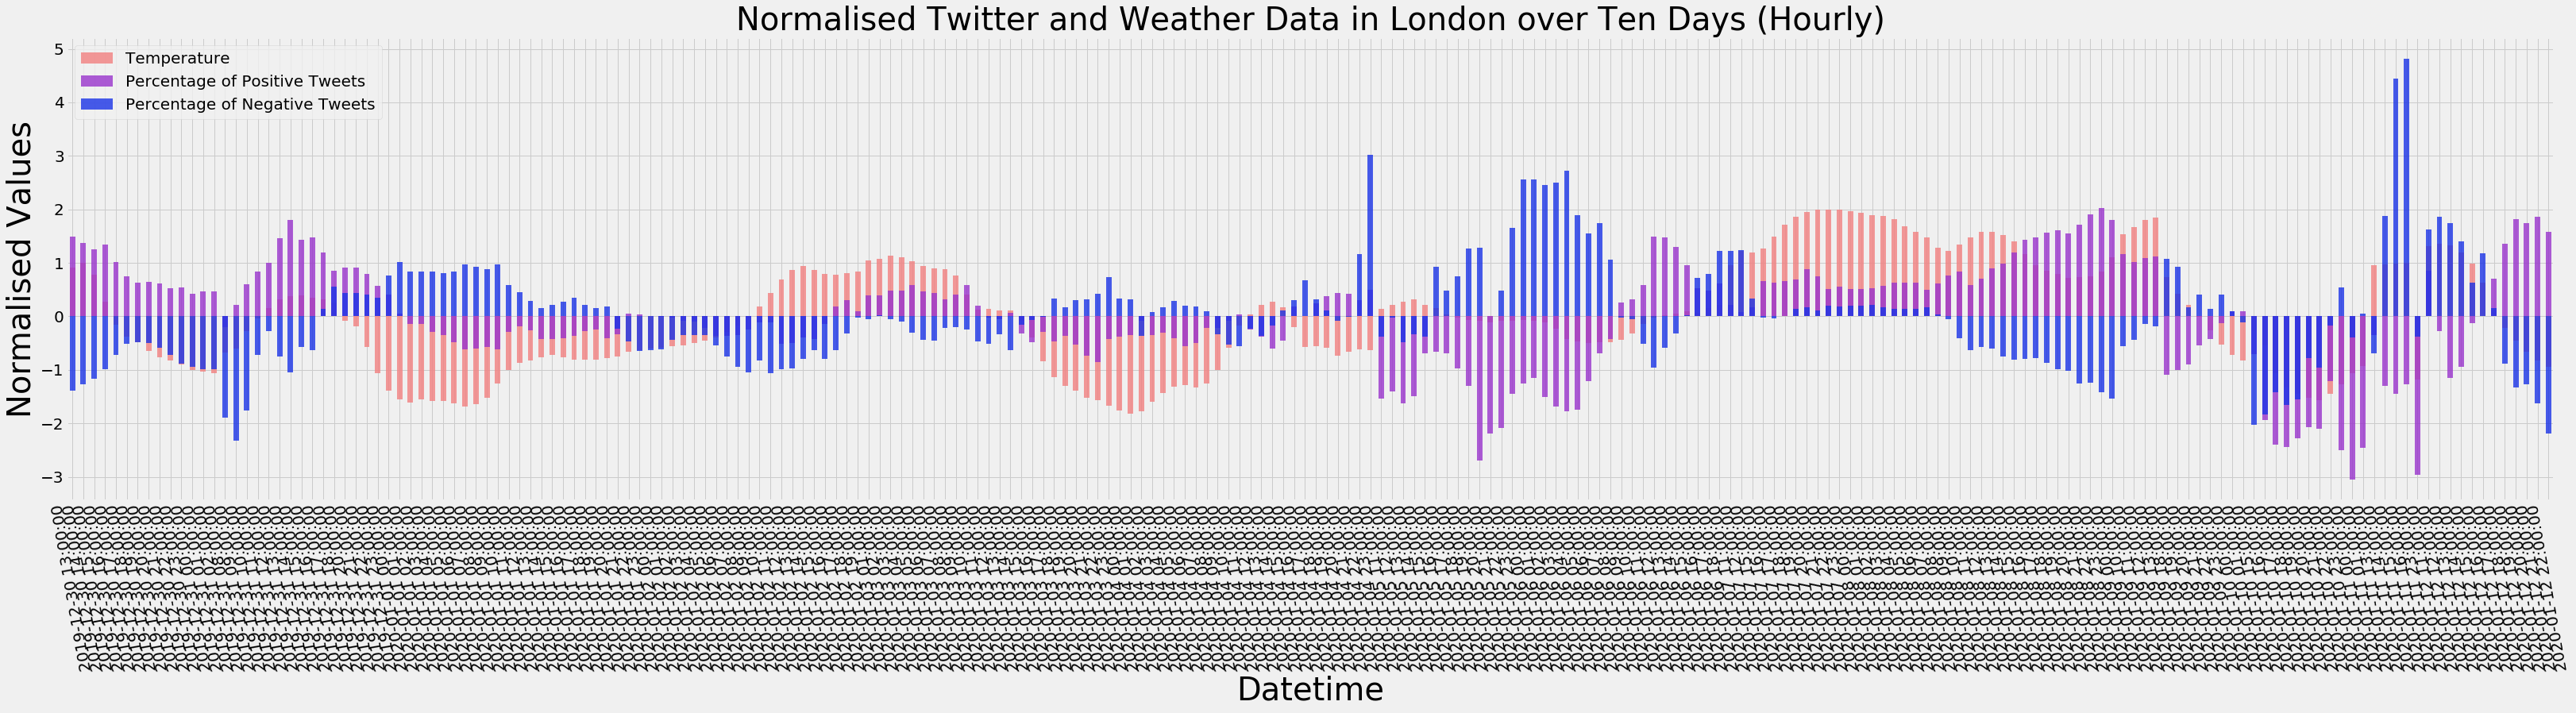

In [215]:
plt.figure(figsize=(30, 10))
plt.xlabel('Datetime', fontsize = 40)
plt.ylabel('Normalised Values', fontsize = 40)
plt.title("Normalised Twitter and Weather Data in London over Ten Days (Hourly)", fontsize = 40)

#HourSampleLNWeather = (HourSampleL.Weather - np.mean(HourSampleL.Weather))/np.std(HourSampleL.Weather)
#HourSampleLNWinsS = (HourSampleL.Wind_Speed - np.mean(HourSampleL.Wind_Speed))/np.std(HourSampleL.Wind_Speed)
HourSampleLNTemp = (HourSampleL.Temperature - np.mean(HourSampleL.Temperature))/np.std(HourSampleL.Temperature)
#HourSampleLNTwitNo = (HourSampleL.NumberTweets - np.mean(HourSampleL.NumberTweets))/np.std(HourSampleL.NumberTweets)
HourSampleLNTwitPos = (HourSampleL.Positive_Percentage_Climate_Tweets - np.mean(HourSampleL.Positive_Percentage_Climate_Tweets))/np.std(HourSampleL.Positive_Percentage_Climate_Tweets)
HourSampleLNTwitNeg = (HourSampleL.Negetive_Percentage_Climate_Tweets - np.mean(HourSampleL.Negetive_Percentage_Climate_Tweets))/np.std(HourSampleL.Negetive_Percentage_Climate_Tweets)

#HourSampleLNWeather.plot.bar(color=(0.1, 0.2, 0.5, 0.8),figsize=(50, 10),label ="Weather") 
#HourSampleLNWinsS.plot.bar(color=(0.8, 0.4, 0.1, 0.8), figsize=(50, 10),label ="Wind Speed") 
HourSampleLNTemp.plot.bar(color=(0.95, 0.5, 0.5, 0.8), figsize=(50, 10),label ="Temperature")
#HourSampleLNTwitNo.plot.bar(color=(0.1, 0.8, 0.4, 0.8), figsize=(50, 10),label ="Number of Tweets")
HourSampleLNTwitPos.plot.bar(color=(0.6, 0.2, 0.8, 0.8),figsize=(50,10),label = 'Percentage of Positive Tweets')
HourSampleLNTwitNeg.plot.bar(color=(0.1, 0.2, 0.9, 0.8),figsize=(50,10),label = 'Percentage of Negative Tweets')

plt.legend()
plt.xticks(rotation=100)
plt.show()

#plt.savefig('./graphs/Normalised_data_perHourLondon.png')

### Daily Normalised Data London - Twitter VS Weather

<Figure size 2160x720 with 0 Axes>

Text(0.5, 0, 'Datetime')

Text(0, 0.5, 'Normalised Values')

Text(0.5, 1.0, 'Normalised Twitter and Weather Data in London over Ten Days (Daily)')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

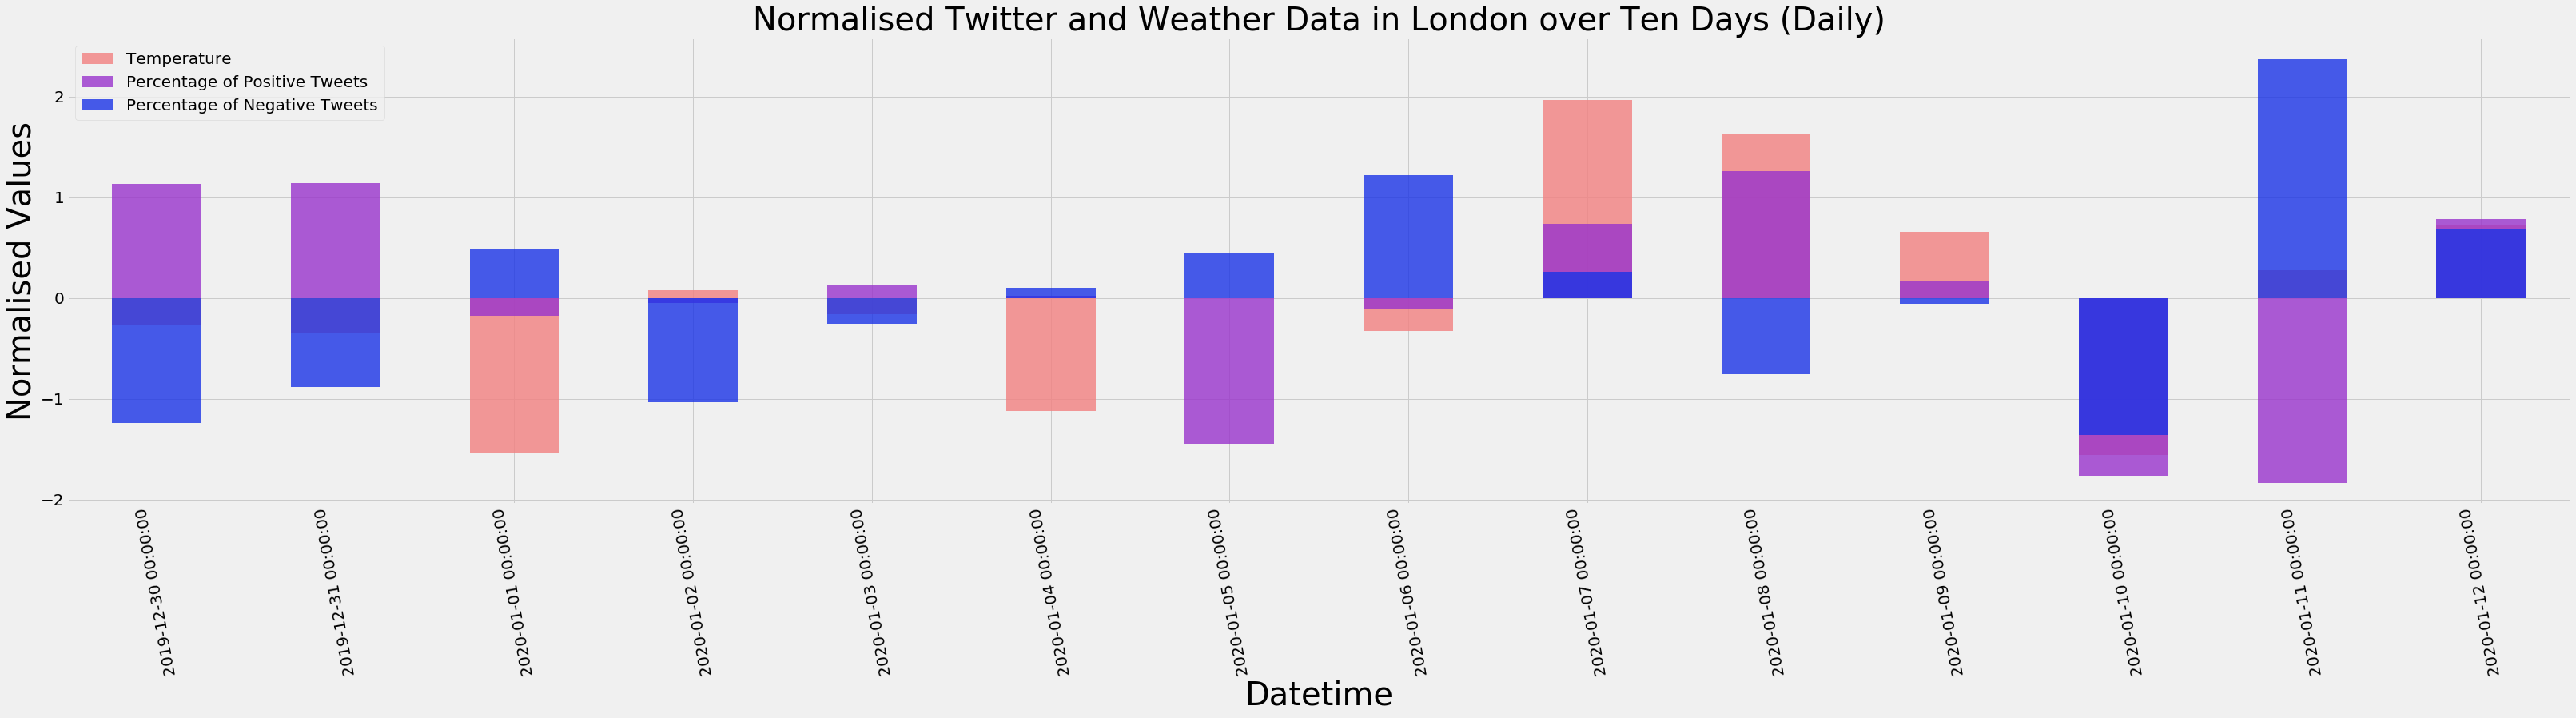

In [216]:
plt.figure(figsize=(30, 10))
plt.xlabel('Datetime', fontsize = 40)
plt.ylabel('Normalised Values', fontsize = 40)
plt.title("Normalised Twitter and Weather Data in London over Ten Days (Daily)", fontsize = 40)

#DaySampleLNWeather = (DaySampleL.Weather - np.mean(DaySampleL.Weather))/np.std(DaySampleL.Weather)
#DaySampleLNWinsS = (DaySampleL.Wind_Speed - np.mean(DaySampleL.Wind_Speed))/np.std(DaySampleL.Wind_Speed)
DaySampleLNTemp = (DaySampleL.Temperature - np.mean(DaySampleL.Temperature))/np.std(DaySampleL.Temperature)
#DaySampleLNTwitNo = (DaySampleL.NumberTweets - np.mean(DaySampleL.NumberTweets))/np.std(DaySampleL.NumberTweets)
DaySampleLNTwitPos = (DaySampleL.Positive_Percentage_Climate_Tweets - np.mean(DaySampleL.Positive_Percentage_Climate_Tweets))/np.std(DaySampleL.Positive_Percentage_Climate_Tweets)
DaySampleLNTwitNeg = (DaySampleL.Negetive_Percentage_Climate_Tweets - np.mean(DaySampleL.Negetive_Percentage_Climate_Tweets))/np.std(DaySampleL.Negetive_Percentage_Climate_Tweets)

#DaySampleLNWeather.plot.bar(color=(0.1, 0.2, 0.5, 0.8),figsize=(50, 10),label ="Weather") 
#DaySampleLNWinsS.plot.bar(color=(0.8, 0.4, 0.1, 0.8), figsize=(50, 10),label ="Wind Speed") 
DaySampleLNTemp.plot.bar(color=(0.95, 0.5, 0.5, 0.8), figsize=(50, 10),label ="Temperature")
#DaySampleLNTwitNo.plot.bar(color=(0.1, 0.8, 0.4, 0.8), figsize=(50, 10),label ="Number of Tweets")
DaySampleLNTwitPos.plot.bar(color=(0.6, 0.2, 0.8, 0.8),figsize=(50,10),label = 'Percentage of Positive Tweets')
DaySampleLNTwitNeg.plot.bar(color=(0.1, 0.2, 0.9, 0.8),figsize=(50,10),label = 'Percentage of Negative Tweets')

plt.legend()
plt.xticks(rotation=100)
plt.show()

#plt.savefig('./graphs/Normalised_data_perDayLondon.png')

### Hourly Normalised Data Sydney - Twitter VS Weather

<Figure size 2160x720 with 0 Axes>

Text(0.5, 0, 'Datetime')

Text(0, 0.5, 'Normalised Values')

Text(0.5, 1.0, 'Normalised Twitter and Weather Data in London over Ten Days (Hourly)')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

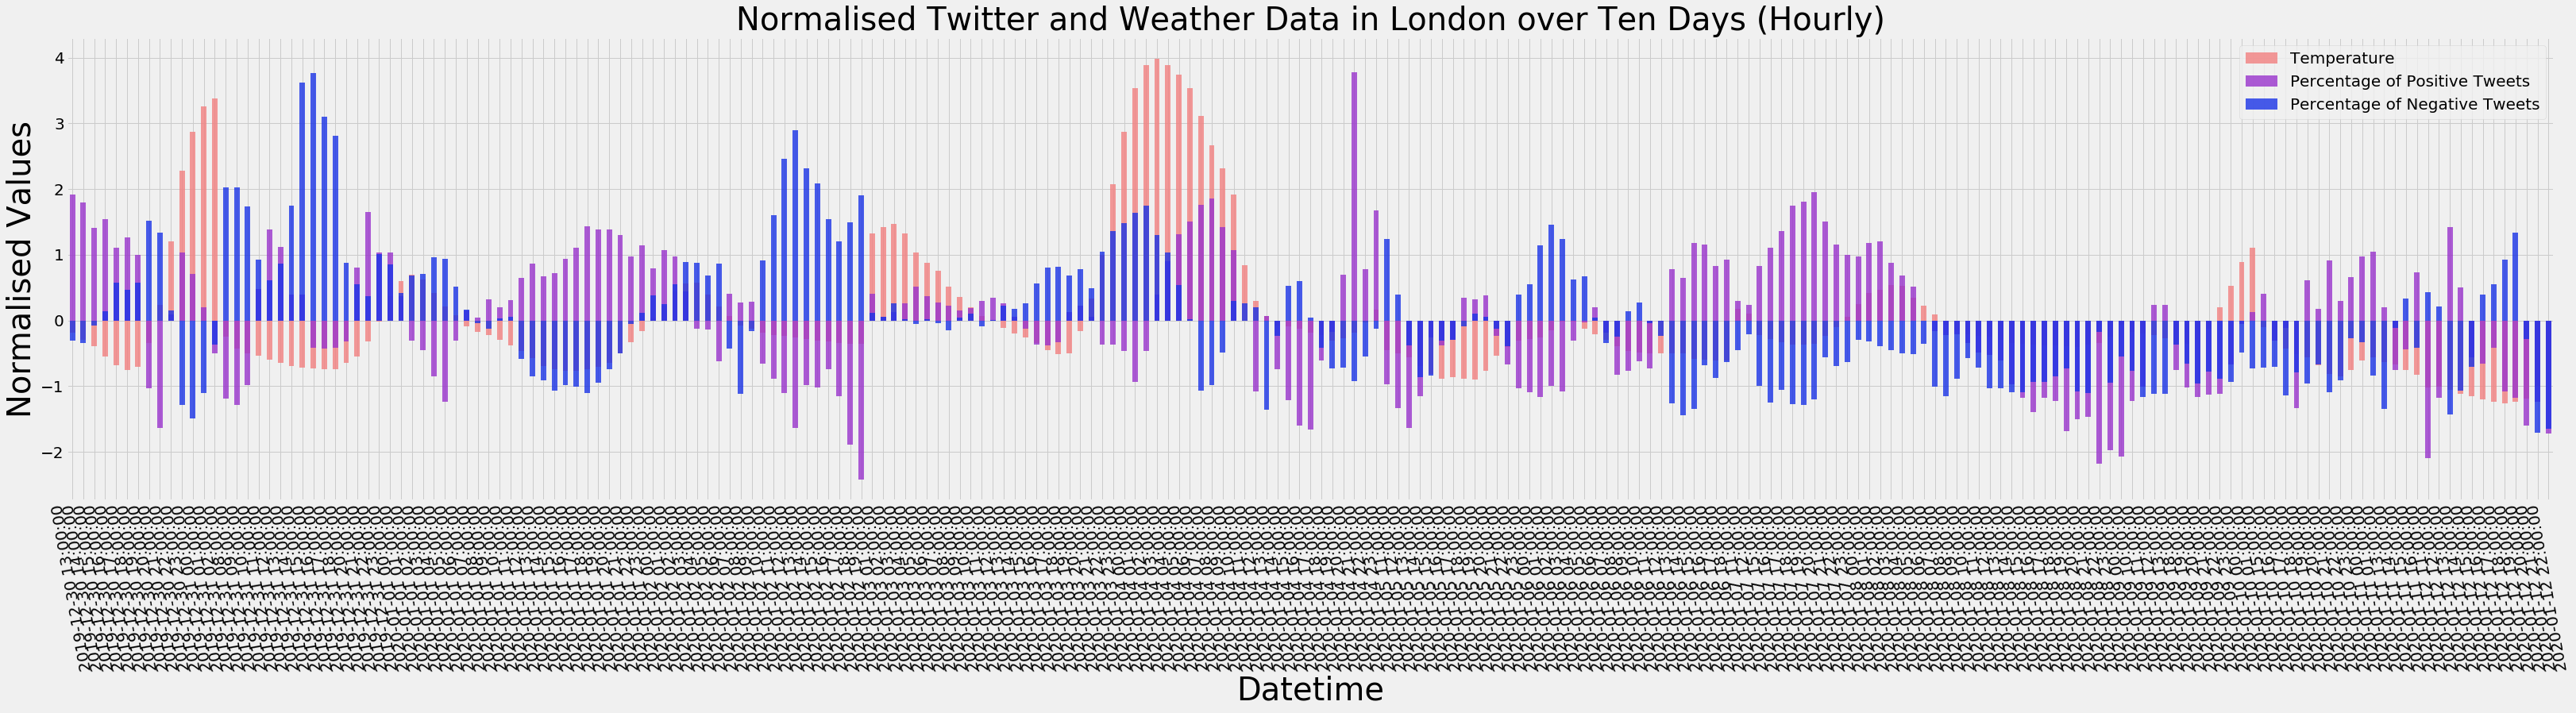

In [217]:
plt.figure(figsize=(30, 10))
plt.xlabel('Datetime', fontsize = 40)
plt.ylabel('Normalised Values', fontsize = 40)
plt.title("Normalised Twitter and Weather Data in London over Ten Days (Hourly)", fontsize = 40)

#HourSampleSNWeather = (HourSampleS.Weather - np.mean(HourSampleS.Weather))/np.std(HourSampleS.Weather)
#HourSampleSNWinsS = (HourSampleS.Wind_Speed - np.mean(HourSampleS.Wind_Speed))/np.std(HourSampleS.Wind_Speed)
HourSampleSNTemp = (HourSampleS.Temperature - np.mean(HourSampleS.Temperature))/np.std(HourSampleS.Temperature)
#HourSampleSNTwitNo = (HourSampleS.NumberTweets - np.mean(HourSampleS.NumberTweets))/np.std(HourSampleL.NumberTweets)
HourSampleSNTwitPos = (HourSampleS.Positive_Percentage_Climate_Tweets - np.mean(HourSampleS.Positive_Percentage_Climate_Tweets))/np.std(HourSampleS.Positive_Percentage_Climate_Tweets)
HourSampleSNTwitNeg = (HourSampleS.Negetive_Percentage_Climate_Tweets - np.mean(HourSampleS.Negetive_Percentage_Climate_Tweets))/np.std(HourSampleS.Negetive_Percentage_Climate_Tweets)

#HourSampleSNWeather.plot.bar(color=(0.1, 0.2, 0.5, 0.8),figsize=(50, 10),label ="Weather") 
#HourSampleSNWinsS.plot.bar(color=(0.8, 0.4, 0.1, 0.8), figsize=(50, 10),label ="Wind Speed") 
HourSampleSNTemp.plot.bar(color=(0.95, 0.5, 0.5, 0.8), figsize=(50, 10),label ="Temperature")
#HourSampleSNTwitNo.plot.bar(color=(0.1, 0.8, 0.4, 0.8), figsize=(50, 10),label ="Number of Tweets")
HourSampleSNTwitPos.plot.bar(color=(0.6, 0.2, 0.8, 0.8),figsize=(50,10),label = 'Percentage of Positive Tweets')
HourSampleSNTwitNeg.plot.bar(color=(0.1, 0.2, 0.9, 0.8),figsize=(50,10),label = 'Percentage of Negative Tweets')

plt.legend()
plt.xticks(rotation=100)
plt.show()

#plt.savefig('./graphs/Normalised_data_perHourSydney.png')

### Daily Normalised Data Sydney - Twitter VS Weather

<Figure size 2160x720 with 0 Axes>

Text(0.5, 0, 'Datetime')

Text(0, 0.5, 'Normalised Values')

Text(0.5, 1.0, 'Normalised Twitter and Weather Data in London over Ten Days (Daily)')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

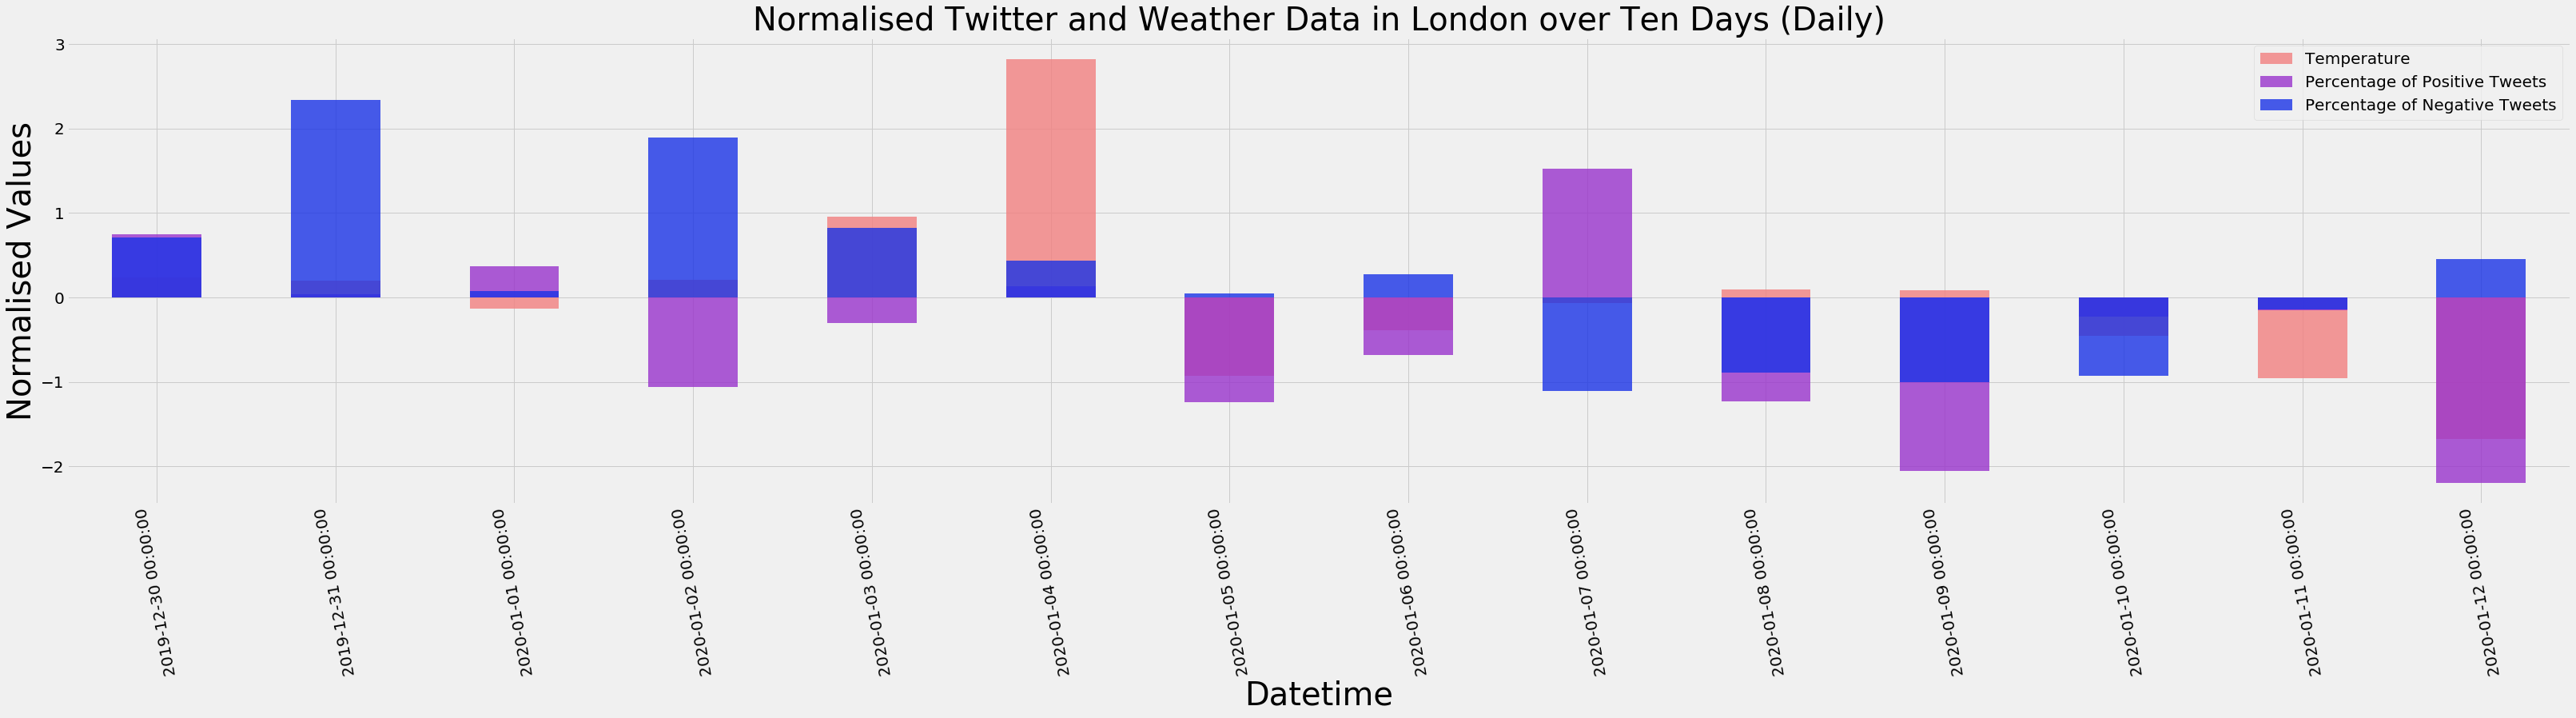

In [218]:
plt.figure(figsize=(30, 10))
plt.xlabel('Datetime', fontsize = 40)
plt.ylabel('Normalised Values', fontsize = 40)
plt.title("Normalised Twitter and Weather Data in London over Ten Days (Daily)", fontsize = 40)

#DaySampleSNWeather = (DaySampleS.Weather - np.mean(DaySampleS.Weather))/np.std(DaySampleS.Weather)
#DaySampleSNWinsS = (DaySampleS.Wind_Speed - np.mean(DaySampleS.Wind_Speed))/np.std(DaySampleS.Wind_Speed)
DaySampleSNTemp = (DaySampleS.Temperature - np.mean(DaySampleS.Temperature))/np.std(DaySampleS.Temperature)
#DaySampleSNTwitNo = (DaySampleS.NumberTweets - np.mean(DaySampleS.NumberTweets))/np.std(DaySampleS.NumberTweets)
DaySampleSNTwitPos = (DaySampleS.Positive_Percentage_Climate_Tweets - np.mean(DaySampleL.Positive_Percentage_Climate_Tweets))/np.std(DaySampleS.Positive_Percentage_Climate_Tweets)
DaySampleSNTwitNeg = (DaySampleS.Negetive_Percentage_Climate_Tweets - np.mean(DaySampleL.Negetive_Percentage_Climate_Tweets))/np.std(DaySampleS.Negetive_Percentage_Climate_Tweets)

#DaySampleSNWeather.plot.bar(color=(0.1, 0.2, 0.5, 0.8),figsize=(50, 10),label ="Weather") 
#DaySampleSNWinsS.plot.bar(color=(0.8, 0.4, 0.1, 0.8), figsize=(50, 10),label ="Wind Speed") 
DaySampleSNTemp.plot.bar(color=(0.95, 0.5, 0.5, 0.8), figsize=(50, 10),label ="Temperature")
#DaySampleSNTwitNo.plot.bar(color=(0.1, 0.8, 0.4, 0.8), figsize=(50, 10),label ="Number of Tweets")
DaySampleSNTwitPos.plot.bar(color=(0.6, 0.2, 0.8, 0.8),figsize=(50,10),label = 'Percentage of Positive Tweets')
DaySampleSNTwitNeg.plot.bar(color=(0.1, 0.2, 0.9, 0.8),figsize=(50,10),label = 'Percentage of Negative Tweets')

plt.legend()
plt.xticks(rotation=100)
plt.show()

#plt.savefig('./graphs/Normalised_data_perDaySydney.png')

# 6. Autocorrelation

## Weather Autocorrelation

### A) London Weather 

In [219]:
WeatherAC = HourSampleL["Weather"].corr(DaySampleL["Weather"]) # weather in london sampled hourly vs sampled daily 
Wind_SpeedAC = HourSampleL["Wind_Speed"].corr(DaySampleL["Wind_Speed"])
TempAC = HourSampleL["Temperature"].corr(DaySampleL["Temperature"])

WeatherWind = HourSampleL["Weather"].corr(HourSampleL["Wind_Speed"]) # weather in London sampled against wind speed
WeatherTemp = HourSampleL["Weather"].corr(HourSampleL["Temperature"])
WindTemp = HourSampleL["Wind_Speed"].corr(HourSampleL["Temperature"])

WeatherAC, Wind_SpeedAC, TempAC
WeatherWind, WeatherTemp, WindTemp

(-0.21528610570507395, 0.13164071596938862, 0.8142330072011594)

(0.05722708743106979, 0.08063025089150568, 0.6209738314990969)

### B) Sydney Weather 

In [220]:
WeatherAC = HourSampleS["Weather"].corr(DaySampleS["Weather"])
Wind_SpeedAC = HourSampleS["Wind_Speed"].corr(DaySampleS["Wind_Speed"])
TempAC = HourSampleS["Temperature"].corr(DaySampleS["Temperature"])

WeatherWind = HourSampleS["Weather"].corr(HourSampleS["Wind_Speed"])
WeatherTemp = HourSampleS["Weather"].corr(HourSampleS["Temperature"])
WindTemp = HourSampleS["Wind_Speed"].corr(HourSampleS["Temperature"])
WeatherVisibility = HourSampleS["Weather"].corr(HourSampleS["Visibility"])

WeatherAC, Wind_SpeedAC, TempAC
WeatherWind, WeatherTemp, WindTemp, WeatherVisibility

(0.6285963613427702, 0.27227587356345934, 0.7135862219097503)

(0.26558451325802285,
 -0.05178592079062689,
 0.2648202928582046,
 -0.5837400945137495)

## Twitter Autocorrelation

### A) London Twitter 

In [221]:
NumberTweetsAC = HourSampleL["NumberTweets"].corr(DaySampleL["NumberTweets"])
PosPercentAC = HourSampleL["Positive_Percentage_Climate_Tweets"].corr(DaySampleL["Positive_Percentage_Climate_Tweets"])
NegPercentAC = HourSampleL["Negetive_Percentage_Climate_Tweets"].corr(DaySampleL["Negetive_Percentage_Climate_Tweets"])

NumberPos = HourSampleL["NumberTweets"].corr(HourSampleL["Positive_Percentage_Climate_Tweets"])
NumberNeg = HourSampleL["NumberTweets"].corr(HourSampleL["Negetive_Percentage_Climate_Tweets"])
PosNeg = HourSampleL["Positive_Percentage_Climate_Tweets"].corr(HourSampleL["Negetive_Percentage_Climate_Tweets"])
PosNeu = HourSampleL["Positive_Percentage_Climate_Tweets"].corr(HourSampleL["Neutral_Percentage_Climate_Tweets"])

NumberTweetsAC, PosPercentAC, NegPercentAC
NumberPos, NumberNeg, PosNeg, PosNeu

(0.6503149871978964, 0.5786139729854497, 0.3412720413008993)

(0.2730758501866864,
 -0.3029952183132046,
 -0.36930042724622514,
 -0.7730747137411399)

### B) Sydney Twitter 

In [234]:
NumberTweetsAC = HourSampleS["NumberTweets"].corr(DaySampleS["NumberTweets"])
PosPercentAC = HourSampleS["Positive_Percentage_Climate_Tweets"].corr(DaySampleS["Positive_Percentage_Climate_Tweets"])
NegPercentAC = HourSampleS["Negetive_Percentage_Climate_Tweets"].corr(DaySampleS["Negetive_Percentage_Climate_Tweets"])

NumberPos = HourSampleS["NumberTweets"].corr(HourSampleS["Positive_Percentage_Climate_Tweets"])
NumberNeg = HourSampleS["NumberTweets"].corr(HourSampleS["Negetive_Percentage_Climate_Tweets"])
PosNeg = HourSampleS["Positive_Percentage_Climate_Tweets"].corr(HourSampleS["Negetive_Percentage_Climate_Tweets"])
PosNeu = HourSampleS["Positive_Percentage_Climate_Tweets"].corr(HourSampleS["Neutral_Percentage_Climate_Tweets"])
NegNeu = HourSampleS["Negetive_Percentage_Climate_Tweets"].corr(HourSampleS["Neutral_Percentage_Climate_Tweets"])

NumberTweetsAC, PosPercentAC, NegPercentAC
NumberPos, NumberNeg, PosNeg, PosNeu, NegNeu

(0.28388651774267104, 0.5186579839356171, -0.07012053393700475)

(0.26164575351468156,
 -0.010666298534523815,
 -0.28168212689033495,
 -0.6085852243574695,
 -0.5899308236494155)

# 7. Correlation

### A) London Correlation Hourly - Weather VS Tweets

In [223]:
WeatherNumber = HourSampleL["Weather"].corr(HourSampleL.NumberTweets)
WindNumber = HourSampleL["Wind_Speed"].corr(HourSampleL.NumberTweets)
TempNumber = HourSampleL["Temperature"].corr(HourSampleL.NumberTweets)

WeatherPos = HourSampleL["Weather"].corr(HourSampleL.Positive_Percentage_Climate_Tweets)
WindPos = HourSampleL["Wind_Speed"].corr(HourSampleL.Positive_Percentage_Climate_Tweets)
TempPos = HourSampleL["Temperature"].corr(HourSampleL.Positive_Percentage_Climate_Tweets)

WeatherNeg = HourSampleL["Weather"].corr(HourSampleL.Negetive_Percentage_Climate_Tweets)
WindNeg = HourSampleL["Wind_Speed"].corr(HourSampleL.Negetive_Percentage_Climate_Tweets)
TempNeg = HourSampleL["Temperature"].corr(HourSampleL.Negetive_Percentage_Climate_Tweets)

TempNeu = HourSampleL["Temperature"].corr(HourSampleL.Neutral_Percentage_Climate_Tweets)
                                        
WeatherNumber, WindNumber, TempNumber
WeatherPos, WindPos, TempPos
WeatherNeg, WindNeg, TempNeg, TempNeu

(0.07322562128411991, -0.26731046508337397, 0.03899401089728809)

(0.007119172435114642, 0.07560440365985846, 0.3956564668971174)

(0.17542786340151797,
 0.21219649387511252,
 -0.016054051999998254,
 -0.39464787629894643)

### B) London Correlation Daily - Weather VS Tweets

(0.08442411225432138, -0.3435004519933846, -0.045386393188766486)

(-0.06252757565696168, 0.05782186722466503, 0.42868878907099645)

(0.20300281814905657,
 0.528310657785127,
 0.1337920754907235,
 -0.5377798284332826)

Text(0.5, 1.0, 'Abalone Feature Correlation: London Daily')

[Text(0, 0, 'No.Tweets'),
 Text(0, 0, 'Pos %'),
 Text(0, 0, 'Neg %'),
 Text(0, 0, 'Neutral %'),
 Text(0, 0, 'Weather'),
 Text(0, 0, 'Wind Speed'),
 Text(0, 0, 'Temp'),
 Text(0, 0, 'Visibility')]

[Text(0, 0, 'No.Tweets'),
 Text(0, 0, 'Pos %'),
 Text(0, 0, 'Neg %'),
 Text(0, 0, 'Neutral %'),
 Text(0, 0, 'Weather'),
 Text(0, 0, 'Wind Speed'),
 Text(0, 0, 'Temp'),
 Text(0, 0, 'Visibility')]

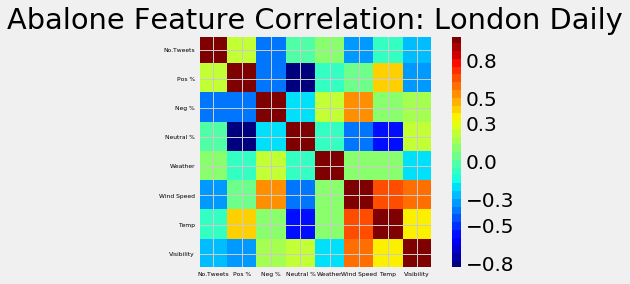

In [224]:
WeatherNumber = DaySampleL["Weather"].corr(DaySampleL.NumberTweets)
WindNumber = DaySampleL["Wind_Speed"].corr(DaySampleL.NumberTweets)
TempNumber = DaySampleL["Temperature"].corr(DaySampleL.NumberTweets)

WeatherPos = DaySampleL["Weather"].corr(DaySampleL.Positive_Percentage_Climate_Tweets)
WindPos = DaySampleL["Wind_Speed"].corr(DaySampleL.Positive_Percentage_Climate_Tweets)
TempPos = DaySampleL["Temperature"].corr(DaySampleL.Positive_Percentage_Climate_Tweets)

WeatherNeg = DaySampleL["Weather"].corr(DaySampleL.Negetive_Percentage_Climate_Tweets)
WindNeg = DaySampleL["Wind_Speed"].corr(DaySampleL.Negetive_Percentage_Climate_Tweets)
TempNeg = DaySampleL["Temperature"].corr(DaySampleL.Negetive_Percentage_Climate_Tweets)
TempNeu = DaySampleL["Temperature"].corr(DaySampleL.Neutral_Percentage_Climate_Tweets)
                                        
WeatherNumber, WindNumber, TempNumber
WeatherPos, WindPos, TempPos
WeatherNeg, WindNeg, TempNeg, TempNeu

fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax1.imshow(DaySampleL.corr(), interpolation="nearest", cmap=cmap)
ax1.grid(True)
plt.title('Abalone Feature Correlation: London Daily')
labels=['No.Tweets','Pos %','Neg %','Neutral %','Weather','Wind Speed','Temp', 'Visibility']
ax1.set_xticks(np.arange(len(labels)))
ax1.set_yticks(np.arange(len(labels)))
ax1.set_xticklabels(labels,fontsize=6)
ax1.set_yticklabels(labels,fontsize=6)

fig.colorbar(cax, ticks=[-0.80,-0.50,-0.30,0,.30,.50,.80])
plt.show()
#plt.savefig('./graphs/abeloneLondonDaily.png')

### C) Sydney Correlation Hourly - Weather VS Tweets

In [225]:
WeatherNumber = HourSampleS["Weather"].corr(HourSampleS.NumberTweets)
WindNumber = HourSampleS["Wind_Speed"].corr(HourSampleS.NumberTweets)
TempNumber = HourSampleS["Temperature"].corr(HourSampleS.NumberTweets)

WeatherPos = HourSampleS["Weather"].corr(HourSampleS.Positive_Percentage_Climate_Tweets)
WindPos = HourSampleS["Wind_Speed"].corr(HourSampleS.Positive_Percentage_Climate_Tweets)
TempPos = HourSampleS["Temperature"].corr(HourSampleS.Positive_Percentage_Climate_Tweets)

WeatherNeg = HourSampleS["Weather"].corr(HourSampleS.Negetive_Percentage_Climate_Tweets)
WindNeg = HourSampleS["Wind_Speed"].corr(HourSampleS.Negetive_Percentage_Climate_Tweets)
TempNeg = HourSampleS["Temperature"].corr(HourSampleS.Negetive_Percentage_Climate_Tweets)
                                        
WeatherNumber, WindNumber, TempNumber
WeatherPos, WindPos, TempPos
WeatherNeg, WindNeg, TempNeg

(-0.05214856529127382, 0.03888566698445987, 0.30506406583043294)

(-0.05797226111596081, 0.16816627357598557, 0.16195016625010408)

(-0.26801998118940407, -0.08642009064902315, 0.08157621838240225)

### D) Sydney Correlation Daily - Weather VS Tweets

(0.037884368498754054, 0.08510039424420947, 0.48180039016928733)

(0.033087642422709944, 0.4495654812770547, 0.35484506739146876)

(-0.5451191848956689, -0.21014298968065412, 0.1842596564661299)

(0.36148054309673033, 0.5568683586375813, -0.48834515340672235)

Text(0.5, 1.0, 'Abalone Feature Correlation: Sydney Daily')

[Text(0, 0, 'No.Tweets'),
 Text(0, 0, 'Pos %'),
 Text(0, 0, 'Neg %'),
 Text(0, 0, 'Neutral %'),
 Text(0, 0, 'Weather'),
 Text(0, 0, 'Wind Speed'),
 Text(0, 0, 'Temp'),
 Text(0, 0, 'Visibility')]

[Text(0, 0, 'No.Tweets'),
 Text(0, 0, 'Pos %'),
 Text(0, 0, 'Neg %'),
 Text(0, 0, 'Neutral %'),
 Text(0, 0, 'Weather'),
 Text(0, 0, 'Wind Speed'),
 Text(0, 0, 'Temp'),
 Text(0, 0, 'Visibility')]

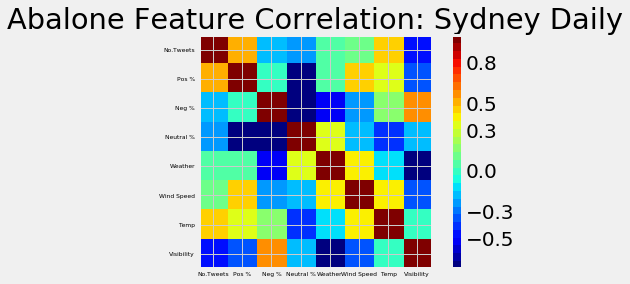

In [226]:
WeatherNumber = DaySampleS["Weather"].corr(DaySampleS.NumberTweets)
WindNumber = DaySampleS["Wind_Speed"].corr(DaySampleS.NumberTweets)
TempNumber = DaySampleS["Temperature"].corr(DaySampleS.NumberTweets)

WeatherPos = DaySampleS["Weather"].corr(DaySampleS.Positive_Percentage_Climate_Tweets)
WindPos = DaySampleS["Wind_Speed"].corr(DaySampleS.Positive_Percentage_Climate_Tweets)
TempPos = DaySampleS["Temperature"].corr(DaySampleS.Positive_Percentage_Climate_Tweets)

WeatherNeg = DaySampleS["Weather"].corr(DaySampleS.Negetive_Percentage_Climate_Tweets)
WindNeg = DaySampleS["Wind_Speed"].corr(DaySampleS.Negetive_Percentage_Climate_Tweets)
TempNeg = DaySampleS["Temperature"].corr(DaySampleS.Negetive_Percentage_Climate_Tweets)
WeatherNeu = DaySampleS["Weather"].corr(DaySampleS.Neutral_Percentage_Climate_Tweets)
VisibilityNeg = DaySampleS["Visibility"].corr(DaySampleS.Negetive_Percentage_Climate_Tweets)
NumbVisibility = DaySampleS["Visibility"].corr(DaySampleS.NumberTweets)

                                        
WeatherNumber, WindNumber, TempNumber
WeatherPos, WindPos, TempPos
WeatherNeg, WindNeg, TempNeg
WeatherNeu, VisibilityNeg, NumbVisibility

fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax1.imshow(DaySampleS.corr(), interpolation="nearest", cmap=cmap)
ax1.grid(True)
plt.title('Abalone Feature Correlation: Sydney Daily')
labels=['No.Tweets','Pos %','Neg %','Neutral %','Weather','Wind Speed','Temp', 'Visibility']
ax1.set_xticks(np.arange(len(labels)))
ax1.set_yticks(np.arange(len(labels)))
ax1.set_xticklabels(labels,fontsize=6)
ax1.set_yticklabels(labels,fontsize=6)

fig.colorbar(cax, ticks=[-0.80,-0.50,-0.30,0,.30,.50,.80])
plt.show()
#plt.savefig('./graphs/abeloneSydneyDaily.png')

### E) Sydney VS London Correlation - Weather & Tweets

NumberTweets_x  Positive_Percentage_Climate_Tweets_x  \
0             40                                  55.0   
1             40                                  55.0   
2             40                                  55.0   
3             40                                  40.0   
4             40                                  37.5   

   Negetive_Percentage_Climate_Tweets_x  Weather_x  Temperature_x  \
0                                  10.0          1           9.83   
1                                  10.0          1           9.84   
2                                  10.0          1           9.87   
3                                  15.0          6           3.39   
4                                  17.5          6           3.56   

  NumberTweets_y  Positive_Percentage_Climate_Tweets_y  \
0             37                             37.837838   
1             37                             37.837838   
2             37                             37.837838   
3             37                             37.837838   
4             37                             37.837838   

   Negetive_Percentage_Climate_Tweets_y  Weather_y  Temperature_y  
0                             10.810811         18           40.0  
1                             10.810811         18           40.0  
2                             10.810811         18           40.0  
3                             10.810811         18           40.0  
4                             10.810811         18           40.0

Text(0.5, 1.0, 'Abalone Feature Correlation: London VS Sydney Daily')

[Text(0, 0, 'No.Tweets'),
 Text(0, 0, 'Pos %'),
 Text(0, 0, 'Neg %'),
 Text(0, 0, 'Neutral %'),
 Text(0, 0, 'Weather'),
 Text(0, 0, 'Wind Speed'),
 Text(0, 0, 'Temp'),
 Text(0, 0, 'Visibility')]

[Text(0, 0, 'No.Tweets'),
 Text(0, 0, 'Pos %'),
 Text(0, 0, 'Neg %'),
 Text(0, 0, 'Neutral %'),
 Text(0, 0, 'Weather'),
 Text(0, 0, 'Wind Speed'),
 Text(0, 0, 'Temp'),
 Text(0, 0, 'Visibility')]

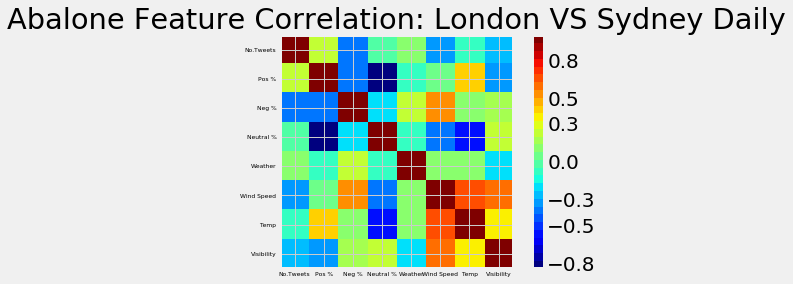

In [227]:
LondonCorr = LondonCSV[['NumberTweets', 'Positive_Percentage_Climate_Tweets', 'Negetive_Percentage_Climate_Tweets', 'Weather', 'Temperature']]
SydneyCorr = SydneyCSV[['NumberTweets', 'Positive_Percentage_Climate_Tweets', 'Negetive_Percentage_Climate_Tweets', 'Weather', 'Temperature']]

Merged = LondonCorr.merge(SydneyCorr, left_on='NumberTweets', right_on='Temperature')
Merged.head()

fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax1.imshow(DaySampleL.corr(), interpolation="nearest", cmap=cmap)
ax1.grid(True)
plt.title('Abalone Feature Correlation: London VS Sydney Daily')
labels=['No.Tweets','Pos %','Neg %','Neutral %','Weather','Wind Speed','Temp', 'Visibility']
ax1.set_xticks(np.arange(len(labels)))
ax1.set_yticks(np.arange(len(labels)))
ax1.set_xticklabels(labels,fontsize=6)
ax1.set_yticklabels(labels,fontsize=6)

fig.colorbar(cax, ticks=[-0.80,-0.50,-0.30,0,.30,.50,.80])
plt.show()
#plt.savefig('./graphs/abelone.png')

## 8. Seasonality

## A) London Data Seasonality 

C:\Users\Emily\Anaconda3\lib\site-packages\statsmodels\tsa\seasonal.py:153: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


Text(0.5, 1, 'NumberTweets')

Text(0.5, 1, 'Positive_Percentage_Climate_Tweets')

Text(0.5, 1, 'Negetive_Percentage_Climate_Tweets')

Text(0.5, 1, 'Neutral_Percentage_Climate_Tweets')

Text(0.5, 1, 'Temperature')

Text(0.5, 1, 'Visibility')

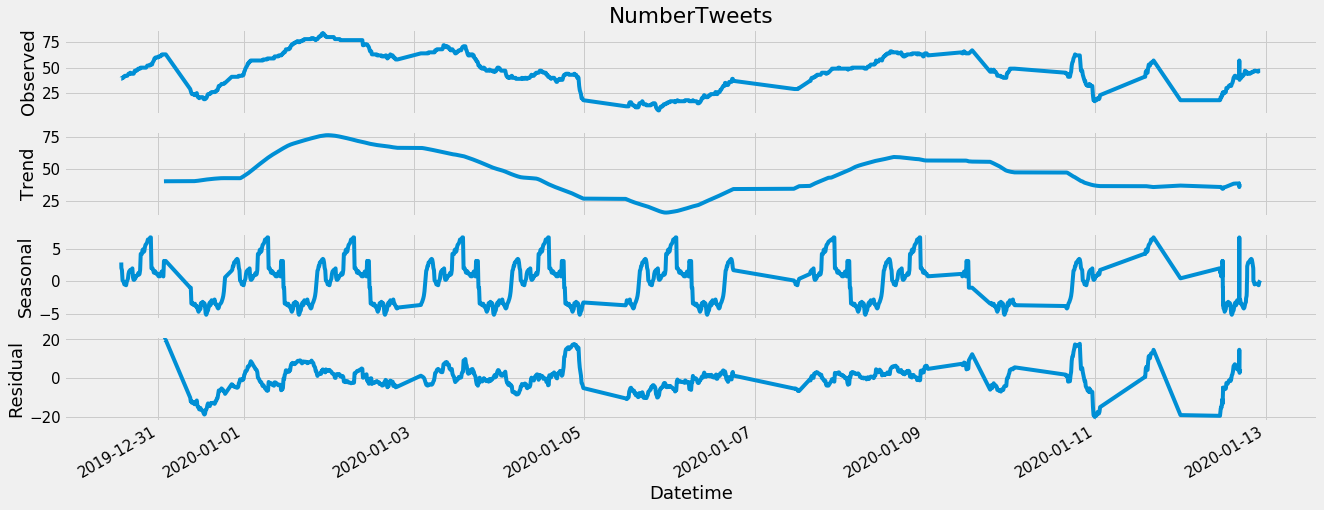

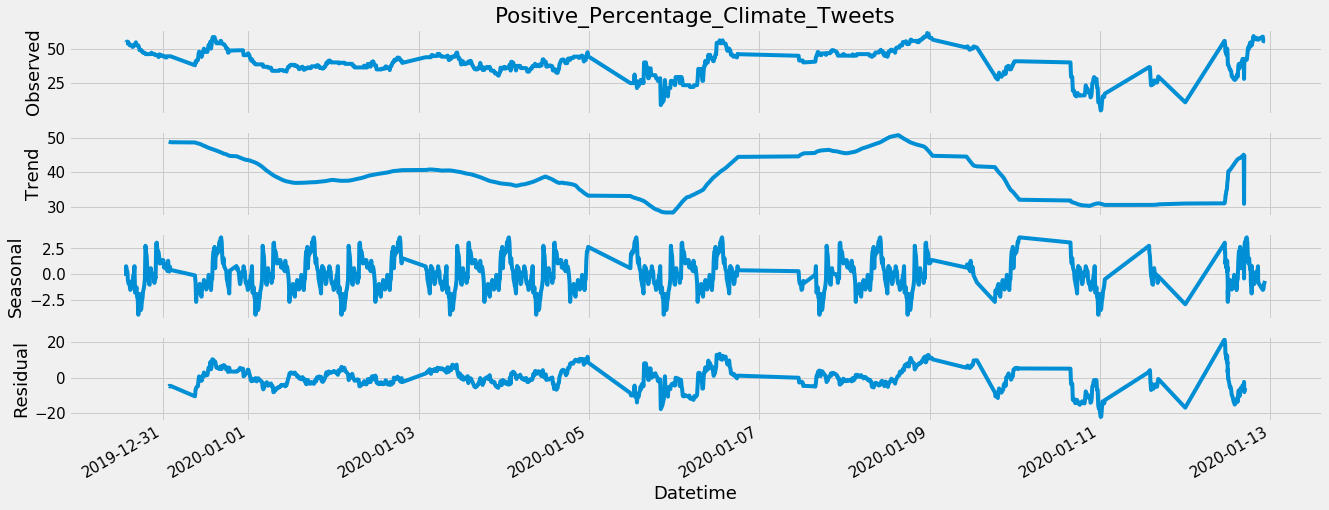

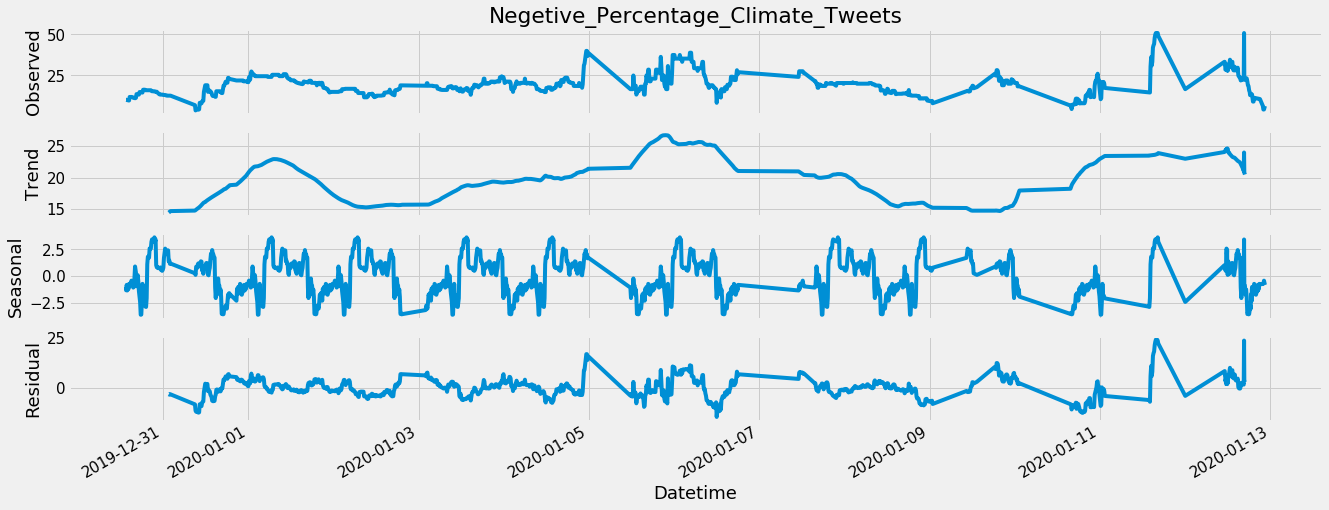

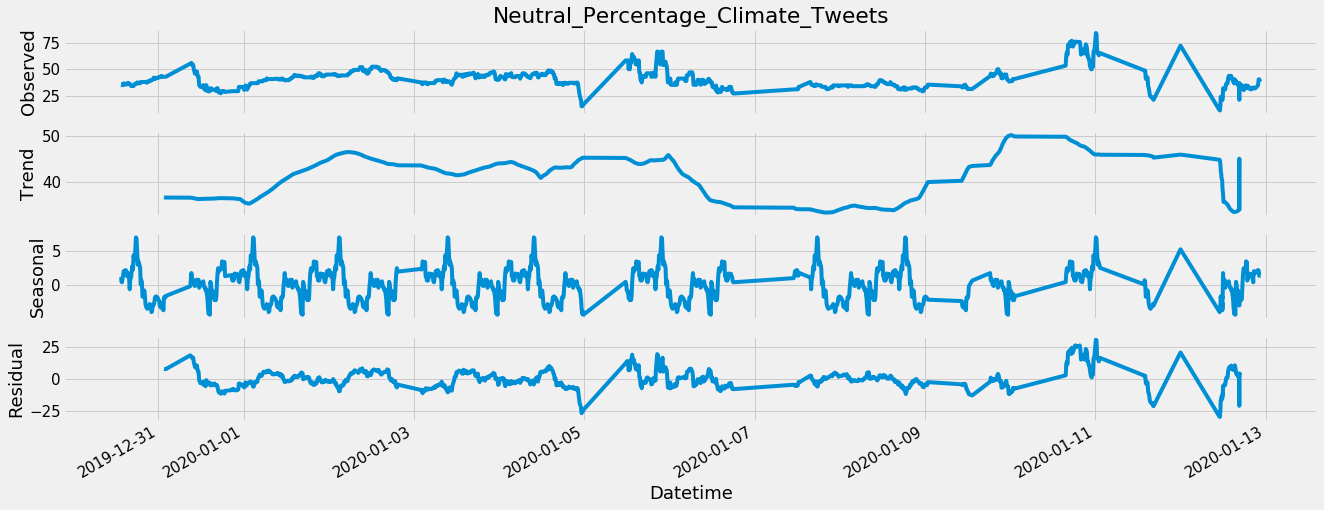

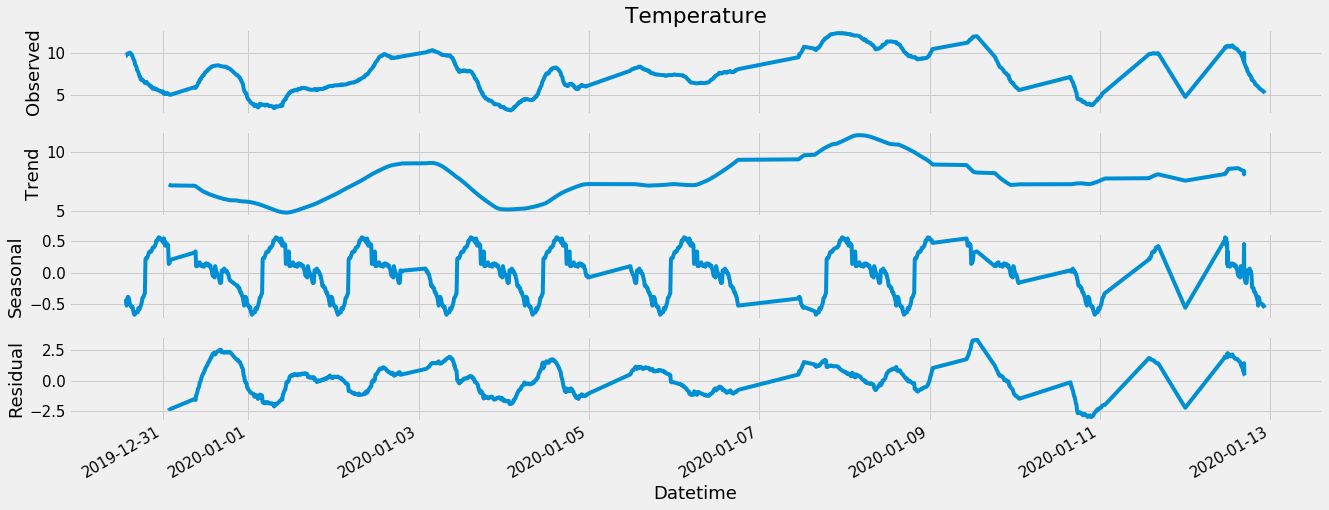

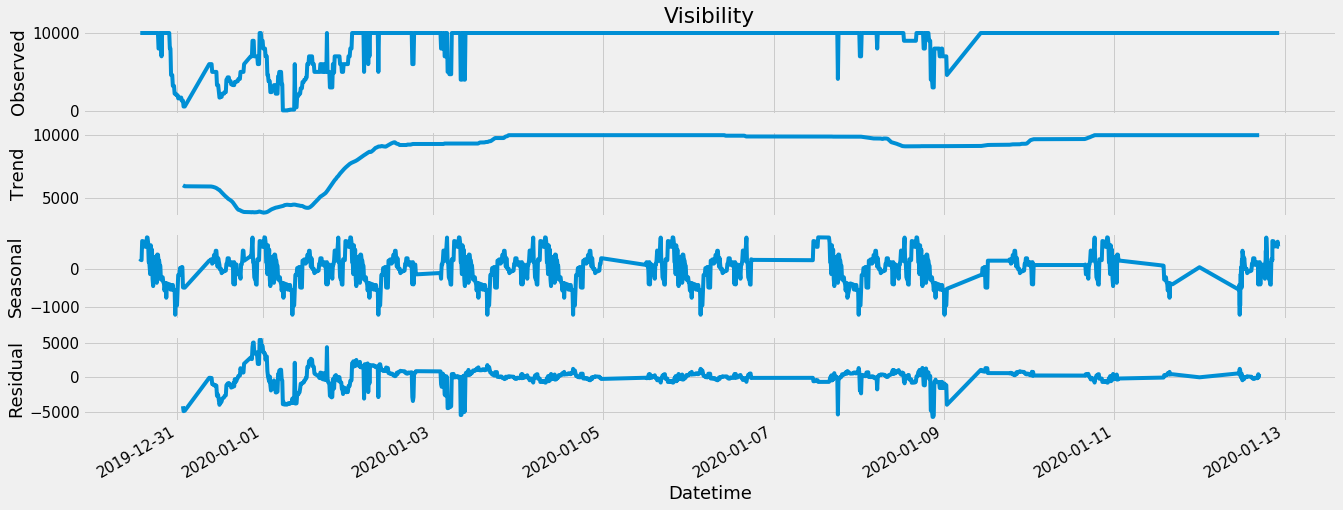

In [232]:
plt.rcParams.update({'font.size': 15})
trend_series = []

LondonCorr = LondonCSV[['NumberTweets', 'Positive_Percentage_Climate_Tweets', 'Negetive_Percentage_Climate_Tweets','Neutral_Percentage_Climate_Tweets', 'Temperature', 'Visibility']]

for i, name in enumerate(LondonCorr.columns.values):
    decomposed = sm.tsa.seasonal_decompose(LondonCorr[name],freq=48*3)
    trend_series.append(decomposed.trend)
    figure = decomposed.plot()
    figure.axes[0].set_title(name)
    figure.set_size_inches(20,8)

trends = pd.concat(trend_series, axis=1)
plt.show()

## Sydney Data Seasonality 

C:\Users\Emily\Anaconda3\lib\site-packages\statsmodels\tsa\seasonal.py:153: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


Text(0.5, 1, 'NumberTweets')

Text(0.5, 1, 'Positive_Percentage_Climate_Tweets')

Text(0.5, 1, 'Negetive_Percentage_Climate_Tweets')

Text(0.5, 1, 'Neutral_Percentage_Climate_Tweets')

Text(0.5, 1, 'Temperature')

Text(0.5, 1, 'Visibility')

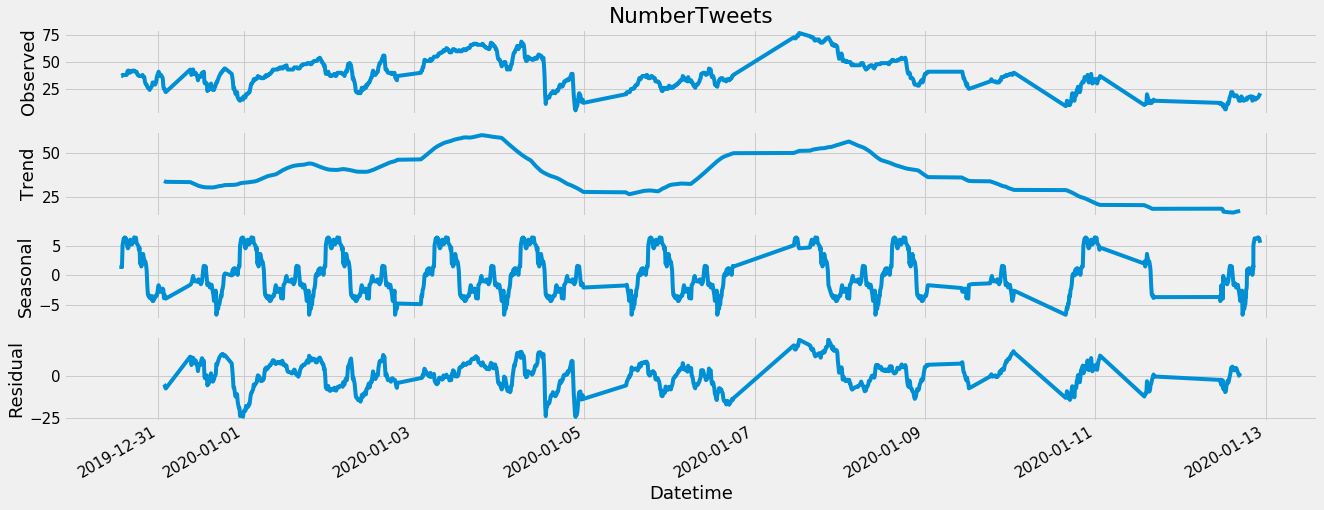

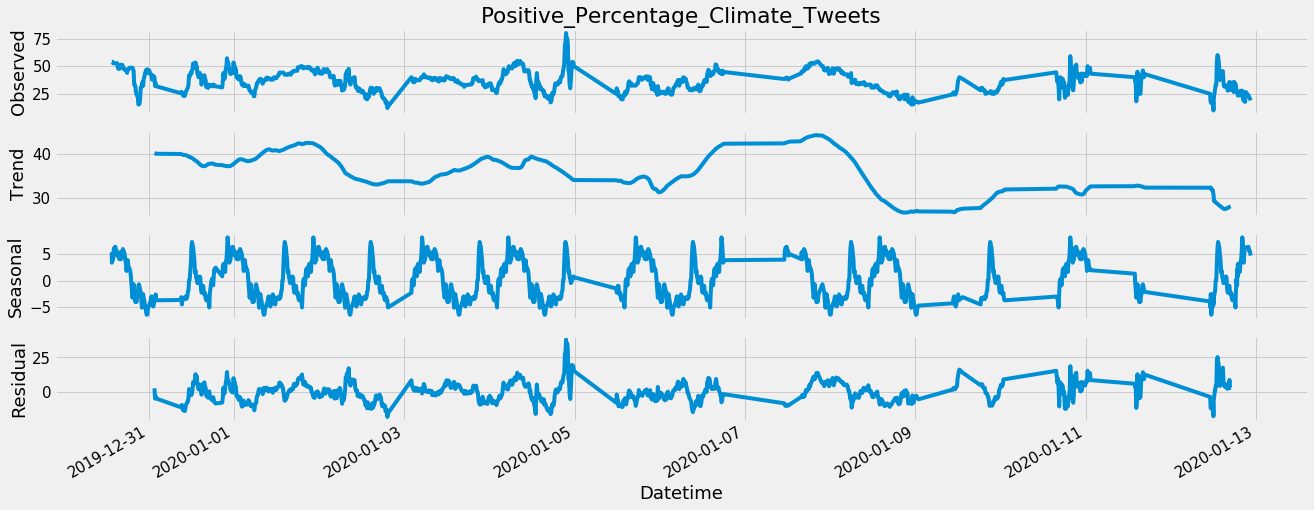

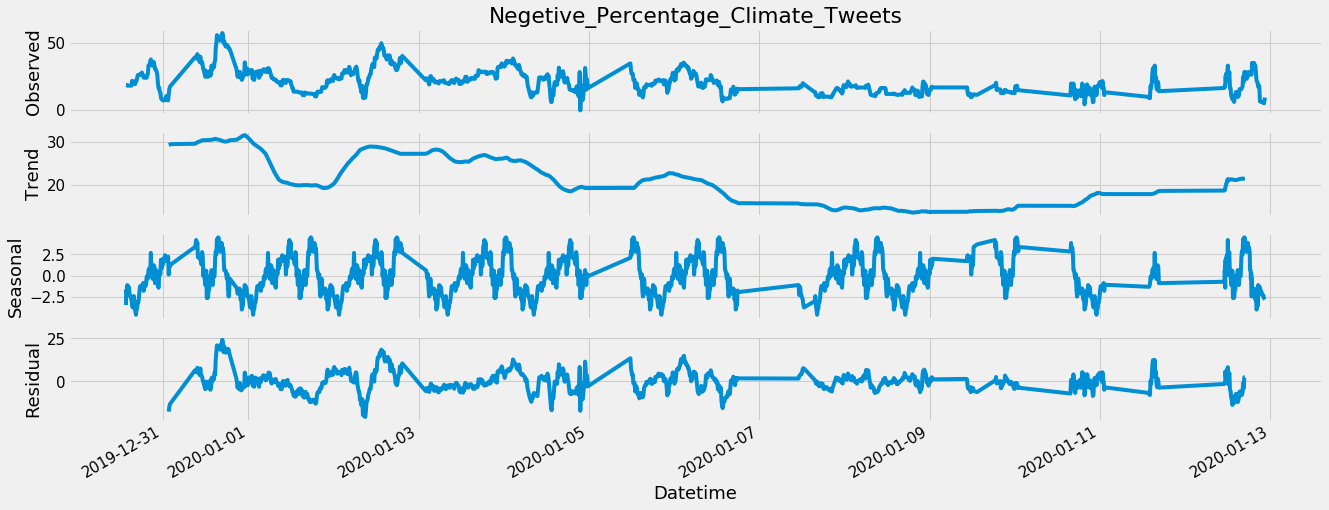

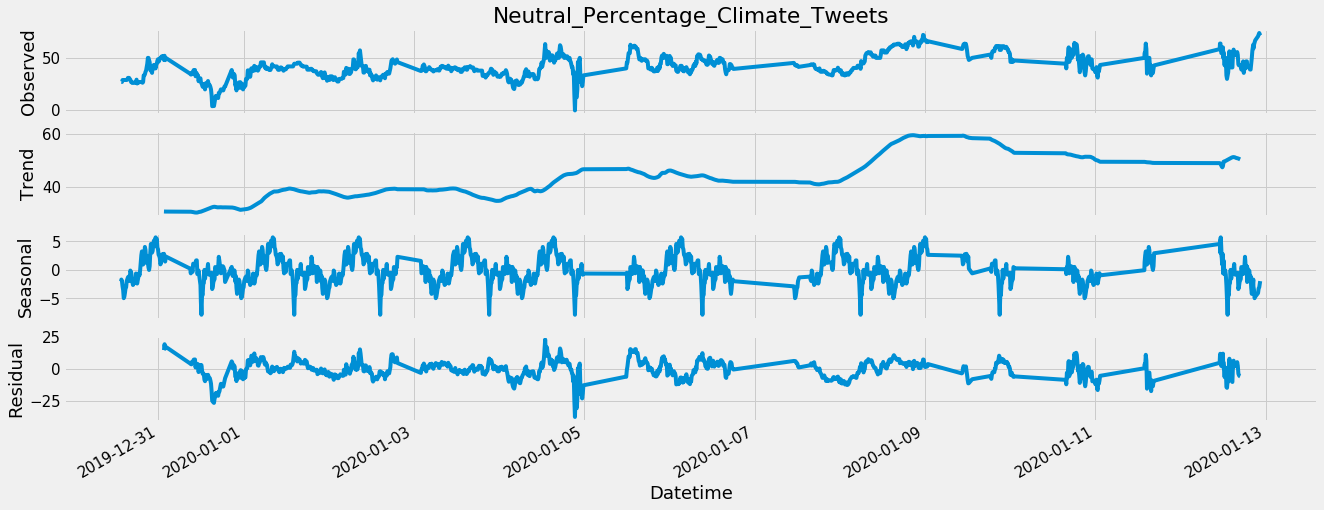

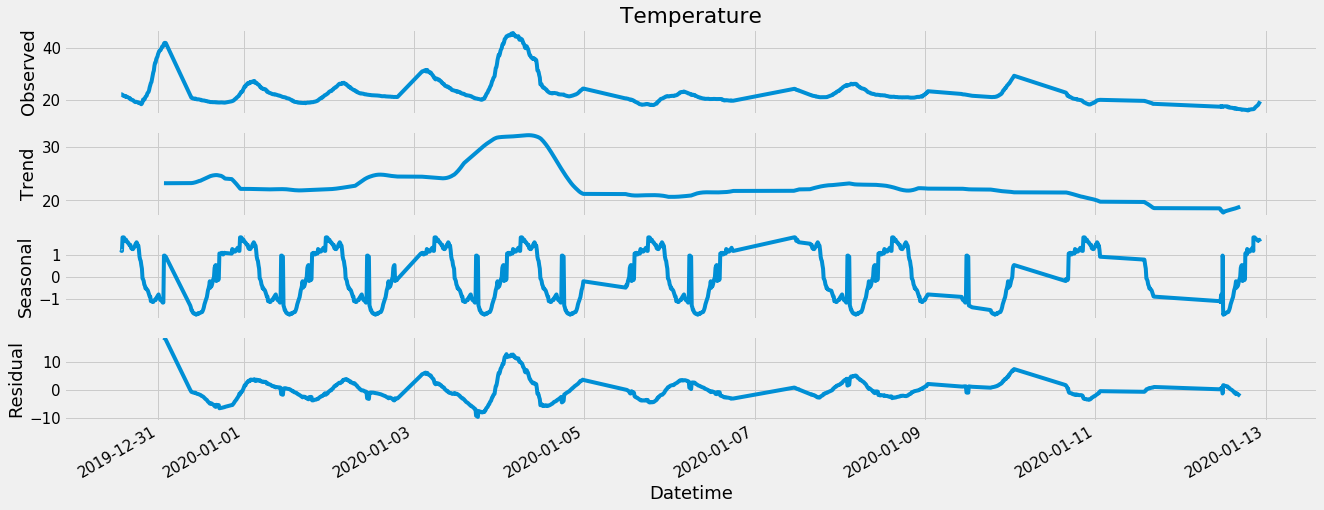

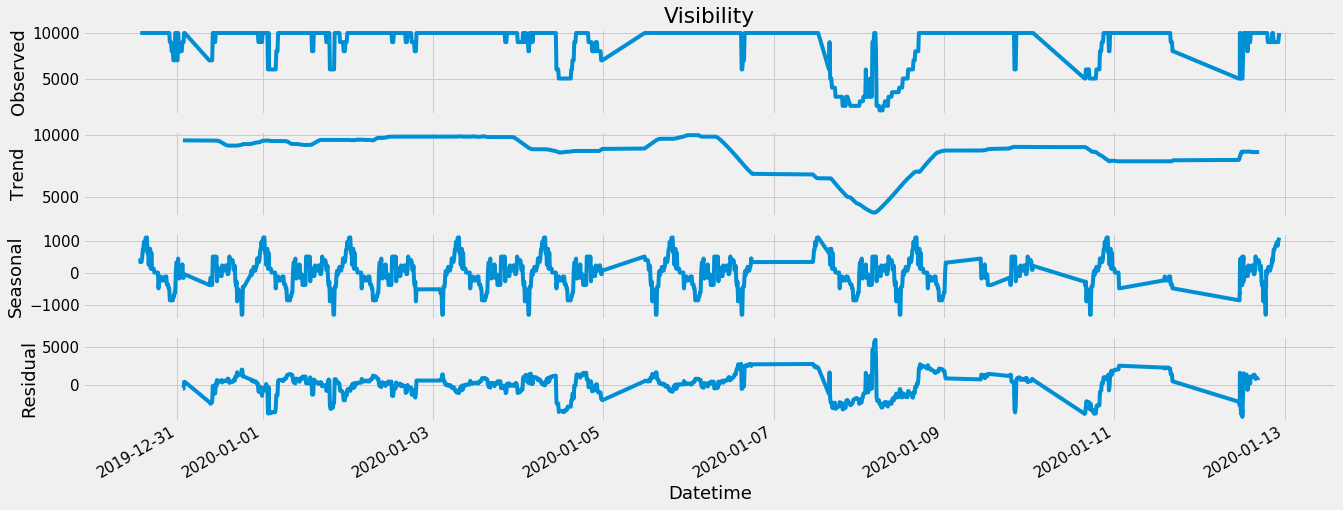

In [233]:
trend_series = []

SydneyCorr = SydneyCSV[['NumberTweets', 'Positive_Percentage_Climate_Tweets', 'Negetive_Percentage_Climate_Tweets','Neutral_Percentage_Climate_Tweets', 'Temperature', 'Visibility']]

for i, name in enumerate(SydneyCorr.columns.values):
    decomposed = sm.tsa.seasonal_decompose(SydneyCorr[name],freq=48*3)
    trend_series.append(decomposed.trend)
    figure = decomposed.plot()
    figure.axes[0].set_title(name)
    figure.set_size_inches(20,8)

trends = pd.concat(trend_series, axis=1)
plt.show()

# Appendix: WordCloud

<Figure size 720x504 with 0 Axes>

(-0.5, 799.5, 499.5, -0.5)

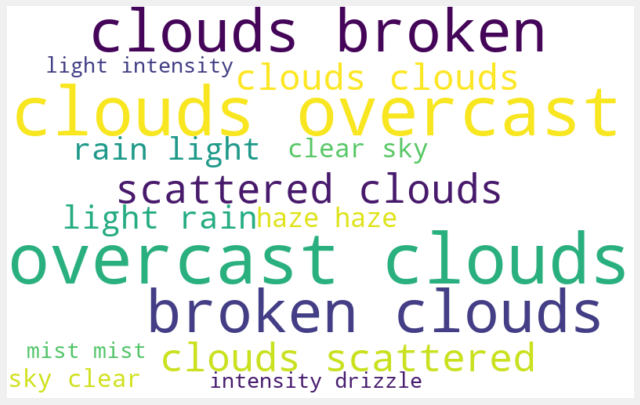

In [231]:
all_words = ' '.join([text for text in LondonCSVWW["Weather"]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=15, background_color="white").generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
#wordcloud.to_file("./graphs/wordmap.png")
plt.axis('off')
plt.show()